In [2]:
import datetime
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datlib.FRED import *
from datlib.plots import *
import pandas_datareader.data as web

%matplotlib inline

# Import Statsmodels

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [3]:
#FRED.py
#. . . 
def bil_to_mil(series):
    return series* 10**3
# . . .
#fedProject.py
# . . .
data_codes  = {# Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
               # Liabilities
               "Balance Sheet: Total Liabilities ($ Mil)" : "WLTLECL",
               "Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)" : "WLFN",
               "Balance Sheet: Reverse Repos ($ Mil)": "WLRRAL",
               ### Major share of deposits 
               "Balance Sheet: Deposits from Dep. Institutions ($ Mil)":"WLODLL",
               "Balance Sheet: U.S. Treasury General Account ($ Mil)": "WDTGAL",
               "Balance Sheet: Other Deposits ($ Mil)": "WOTHLB",
               "Balance Sheet: All Deposits ($ Mil)": "WLDLCL",
               # Capital
               "Balance Sheet: Total Capital": "WCTCL",
               # Interest Rates
               "Unemployment Rate": "UNRATE",
               "Nominal GDP ($ Bil)":"GDP",
               "Real GDP ($ Bil)":"GDPC1",
               "GDP Deflator":"GDPDEF",
               "CPI":"CPIAUCSL",
               "Core PCE":"PCEPILFE",
               "Private Investment":"GPDI",
               "Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Bil)": "WCURCIR",
               "1 Month Treasury Rate (%)": "DGS1MO",
               "3 Month Treasury Rate (%)": "DGS3MO",               
               "1 Year Treasury Rate (%)": "DGS1",
               "2 Year Treasury Rate (%)": "DGS2",
               "10 Year Treasury Rate (%)": "DGS10",
               "30 Year Treasury Rate (%)": "DGS30",               
               "Effective Federal Funds Rate (%)": "DFF",
               "Federal Funds Target Rate (Pre-crisis)":"DFEDTAR",
               "Federal Funds Upper Target":"DFEDTARU",
               "Federal Funds Lower Target":"DFEDTARL",
               "Interest on Reserves (%)": "IOER",
               "VIX": "VIXCLS",
                "5 Year Forward Rate": "T5YIFR"
               }

inflation_target = 2

unemployment_target = 4
# Select start and end dates
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

## year variable automatically adjusts the numper of periods  
#   per year in light of data frequency
annual_div = {"Q":4,
             "W":52,
             "M":12}
### choose frequency
freq = "M"
### set periods per year
year = annual_div[freq]


In [4]:
#data cleaning, importing

d_parser = lambda x: pd.datetime.strptime(x, '%m/%d/%Y')
df = pd.read_csv('M4-8.csv', parse_dates=['Date'], date_parser=d_parser)
df

C:\Users\HP\AppData\Local\Temp/ipykernel_6156/3929515269.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  d_parser = lambda x: pd.datetime.strptime(x, '%m/%d/%Y')


Date  Log M4 including Treasuries  Log Total Assets  \
0   2010-01-31                         7.07             14.63   
1   2010-02-28                         7.06             14.63   
2   2010-03-31                         7.05             14.65   
3   2010-04-30                         7.06             14.66   
4   2010-05-31                         7.06             14.66   
..         ...                          ...               ...   
115 2019-08-31                         7.40             15.14   
116 2019-09-30                         7.40             15.15   
117 2019-10-31                         7.41             15.19   
118 2019-11-30                         7.42             15.21   
119 2019-12-31                         7.42             15.23   

     Effective Federal Funds Rate (%)  Log Currency in Circulation ($ Bil)  \
0                                0.11                                 6.83   
1                                0.13                                 6.83   
2                                0.17                                 6.84   
3                                0.20                                 6.84   
4                                0.20                                 6.84   
..                                ...                                  ...   
115                              2.13                                 7.47   
116                              2.04                                 7.47   
117                              1.83                                 7.48   
118                              1.55                                 7.49   
119                              1.55                                 7.49   

     Log Nominal GDP (Bln)  
0                    16.51  
1                     0.00  
2                     0.00  
3                    16.52  
4                     0.00  
..                     ...  
115                   0.00  
116                   0.00  
117                  16.89  
118                   0.00  
119                   0.00  

[120 rows x 6 columns]

In [5]:
df['Date_at_year_month'] = df['Date'].dt.strftime('%Y-%m')
column_names = {'Date_at_year_month':'DATE',
                'Log M4 including Treasuries':'M4',
                'Log Total Assets': 'TA',
                'Log Currency in Circulation ($ Bil)':'CC',
                'Effective Federal Funds Rate (%)':'FFR',
               'Log Nominal GDP (Bln)':'NGDP'}

# rename columns
df = df.rename(columns = column_names)

df = df.set_index('DATE')
df = df.drop(['Date'], axis = 1)
df

M4     TA   FFR    CC   NGDP
DATE                                   
2010-01  7.07  14.63  0.11  6.83  16.51
2010-02  7.06  14.63  0.13  6.83   0.00
2010-03  7.05  14.65  0.17  6.84   0.00
2010-04  7.06  14.66  0.20  6.84  16.52
2010-05  7.06  14.66  0.20  6.84   0.00
...       ...    ...   ...   ...    ...
2019-08  7.40  15.14  2.13  7.47   0.00
2019-09  7.40  15.15  2.04  7.47   0.00
2019-10  7.41  15.19  1.83  7.48  16.89
2019-11  7.42  15.21  1.55  7.49   0.00
2019-12  7.42  15.23  1.55  7.49   0.00

[120 rows x 5 columns]

In [6]:
data = df

In [7]:
## 1st diff
data_diff = data.diff().dropna()
data_diff

M4    TA   FFR    CC   NGDP
DATE                                  
2010-02 -0.01  0.00  0.02  0.00 -16.51
2010-03 -0.01  0.02  0.04  0.01   0.00
2010-04  0.01  0.01  0.03  0.00  16.52
2010-05  0.00  0.00  0.00  0.00 -16.52
2010-06 -0.01  0.01 -0.02  0.01   0.00
...       ...   ...   ...   ...    ...
2019-08  0.01 -0.01 -0.27  0.00 -16.88
2019-09  0.00  0.01 -0.09  0.00   0.00
2019-10  0.01  0.04 -0.21  0.01  16.89
2019-11  0.01  0.02 -0.28  0.01 -16.89
2019-12  0.00  0.02  0.00  0.00   0.00

[119 rows x 5 columns]

In [8]:
##2nd diff
data_new = data_diff.diff().dropna()
data_new

M4            TA   FFR            CC   NGDP
DATE                                                          
2010-03  8.881784e-16  2.000000e-02  0.02  1.000000e-02  16.51
2010-04  2.000000e-02 -1.000000e-02 -0.01 -1.000000e-02  16.52
2010-05 -1.000000e-02 -1.000000e-02 -0.03  0.000000e+00 -33.04
2010-06 -1.000000e-02  1.000000e-02 -0.02  1.000000e-02  16.52
2010-07  2.000000e-02 -2.000000e-02  0.02 -1.000000e-02  16.53
...               ...           ...   ...           ...    ...
2019-08  1.000000e-02  0.000000e+00 -0.29 -1.000000e-02 -33.76
2019-09 -1.000000e-02  2.000000e-02  0.18  0.000000e+00  16.88
2019-10  1.000000e-02  3.000000e-02 -0.12  1.000000e-02  16.89
2019-11  0.000000e+00 -2.000000e-02 -0.07 -8.881784e-16 -33.78
2019-12 -1.000000e-02 -1.776357e-15  0.28 -1.000000e-02  16.89

[118 rows x 5 columns]

In [9]:
#ADF test

X = data_new["M4"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["FFR"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["TA"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["CC"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
    
X = data_new["NGDP"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")


ADF Statistic: -8.381034
p-value: 0.000000
Critical Values:
	1%: -3.491
	5%: -2.888
	10%: -2.581
Reject Ho - Time Series is Stationary
ADF Statistic: -3.943879
p-value: 0.001735
Critical Values:
	1%: -3.492
	5%: -2.889
	10%: -2.581
Reject Ho - Time Series is Stationary
ADF Statistic: -6.016185
p-value: 0.000000
Critical Values:
	1%: -3.490
	5%: -2.887
	10%: -2.581
Reject Ho - Time Series is Stationary
ADF Statistic: -6.497273
p-value: 0.000000
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582
Reject Ho - Time Series is Stationary
ADF Statistic: -7.884015
p-value: 0.000000
Critical Values:
	1%: -3.492
	5%: -2.889
	10%: -2.581
Reject Ho - Time Series is Stationary


In [10]:
df = data_new

In [11]:
## Partial Correlation

import statsmodels.api as sm

residuals = {}
for y_var in df.keys():
    X_vars = list(df.keys())
    X_vars.remove(y_var)
    X = df[X_vars]
    # Initial estimate should include constant
    #   This won't be the case we regress the errors
    X["Constant"] = 1
    # pass y_var as list for consistent structure
    y = df[[y_var]]
    model = sm.OLS(y, X)
    results = model.fit()
    residuals[y_var] = results.resid
residuals = pd.DataFrame(residuals)
residuals

M4        TA       FFR        CC       NGDP
DATE                                                      
2010-03  0.003780  0.018234  0.015589  0.007703   5.801145
2010-04  0.014876 -0.007126 -0.000445 -0.006159  14.196162
2010-05 -0.009861 -0.010343 -0.012706  0.000103 -22.051291
2010-06 -0.009187  0.006867 -0.046883  0.004987  18.425093
2010-07  0.015256 -0.017089  0.029080 -0.004315  11.306478
...           ...       ...       ...       ...        ...
2019-08 -0.003333  0.003011 -0.241700 -0.014688   9.847521
2019-09 -0.000754  0.018128  0.138835  0.000650  -9.295647
2019-10  0.008110  0.029361 -0.102406  0.004494  21.085242
2019-11 -0.002767 -0.019050 -0.030285  0.001977 -19.801682
2019-12 -0.000235 -0.000724  0.223583 -0.004351 -17.018614

[118 rows x 5 columns]

In [12]:
residuals.corr()[residuals.corr().abs() < 1].mul(-1).fillna(1).round(2)

M4    TA   FFR    CC  NGDP
M4    1.00 -0.12 -0.32 -0.22  0.20
TA   -0.12  1.00 -0.01  0.09  0.08
FFR  -0.32 -0.01  1.00 -0.22  0.43
CC   -0.22  0.09 -0.22  1.00  0.18
NGDP  0.20  0.08  0.43  0.18  1.00

In [13]:
import pingouin
df.pcorr().round(2)

M4    TA   FFR    CC  NGDP
M4    1.00 -0.12 -0.32 -0.22  0.20
TA   -0.12  1.00 -0.01  0.09  0.08
FFR  -0.32 -0.01  1.00 -0.22  0.43
CC   -0.22  0.09 -0.22  1.00  0.18
NGDP  0.20  0.08  0.43  0.18  1.00

In [14]:
pcorr_pvalues = {}
for y, Y in residuals.items():
    pcorr_pvalues[y] = {}
    for x, X in residuals.items():
        if x != y:
            pcorr_pvalues[y][x] = sm.OLS(Y,X).fit().pvalues[x]
        
        else:
            pcorr_pvalues[y][x] = np.NaN
pd.DataFrame(pcorr_pvalues).round(2)

M4    TA   FFR    CC  NGDP
M4     NaN  0.20  0.00  0.02  0.03
TA    0.20   NaN  0.93  0.31  0.40
FFR   0.00  0.93   NaN  0.02  0.00
CC    0.02  0.31  0.02   NaN  0.05
NGDP  0.03  0.40  0.00  0.05   NaN

In [15]:
residuals

M4        TA       FFR        CC       NGDP
DATE                                                      
2010-03  0.003780  0.018234  0.015589  0.007703   5.801145
2010-04  0.014876 -0.007126 -0.000445 -0.006159  14.196162
2010-05 -0.009861 -0.010343 -0.012706  0.000103 -22.051291
2010-06 -0.009187  0.006867 -0.046883  0.004987  18.425093
2010-07  0.015256 -0.017089  0.029080 -0.004315  11.306478
...           ...       ...       ...       ...        ...
2019-08 -0.003333  0.003011 -0.241700 -0.014688   9.847521
2019-09 -0.000754  0.018128  0.138835  0.000650  -9.295647
2019-10  0.008110  0.029361 -0.102406  0.004494  21.085242
2019-11 -0.002767 -0.019050 -0.030285  0.001977 -19.801682
2019-12 -0.000235 -0.000724  0.223583 -0.004351 -17.018614

[118 rows x 5 columns]

In [25]:
##DAG

import pingouin
from pgmpy.estimators import PC
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
from networkx.drawing.nx_agraph import graphviz_layout
import warnings
warnings.filterwarnings("ignore")
from matplotlib.backends.backend_pdf import PdfPages
import networkx as nx

In [17]:
df = data_new
df

M4            TA   FFR            CC   NGDP
DATE                                                          
2010-03  8.881784e-16  2.000000e-02  0.02  1.000000e-02  16.51
2010-04  2.000000e-02 -1.000000e-02 -0.01 -1.000000e-02  16.52
2010-05 -1.000000e-02 -1.000000e-02 -0.03  0.000000e+00 -33.04
2010-06 -1.000000e-02  1.000000e-02 -0.02  1.000000e-02  16.52
2010-07  2.000000e-02 -2.000000e-02  0.02 -1.000000e-02  16.53
...               ...           ...   ...           ...    ...
2019-08  1.000000e-02  0.000000e+00 -0.29 -1.000000e-02 -33.76
2019-09 -1.000000e-02  2.000000e-02  0.18  0.000000e+00  16.88
2019-10  1.000000e-02  3.000000e-02 -0.12  1.000000e-02  16.89
2019-11  0.000000e+00 -2.000000e-02 -0.07 -8.881784e-16 -33.78
2019-12 -1.000000e-02 -1.776357e-15  0.28 -1.000000e-02  16.89

[118 rows x 5 columns]

In [18]:
## Estimating a Directed Acyclic Graph
p_val = .01
from pgmpy.estimators import PC
c = PC(df)
max_cond_vars = len(df.keys())-2


model = c.estimate(return_type = "dag",variant= "parallel",#"orig", "stable"
                   significance_level = p_val, 
                   max_cond_vars = max_cond_vars, ci_test = "pearsonr")
edges = model.edges()

  0%|          | 0/3 [00:00<?, ?it/s]

OutEdgeView([('NGDP', 'FFR'), ('M4', 'FFR')])

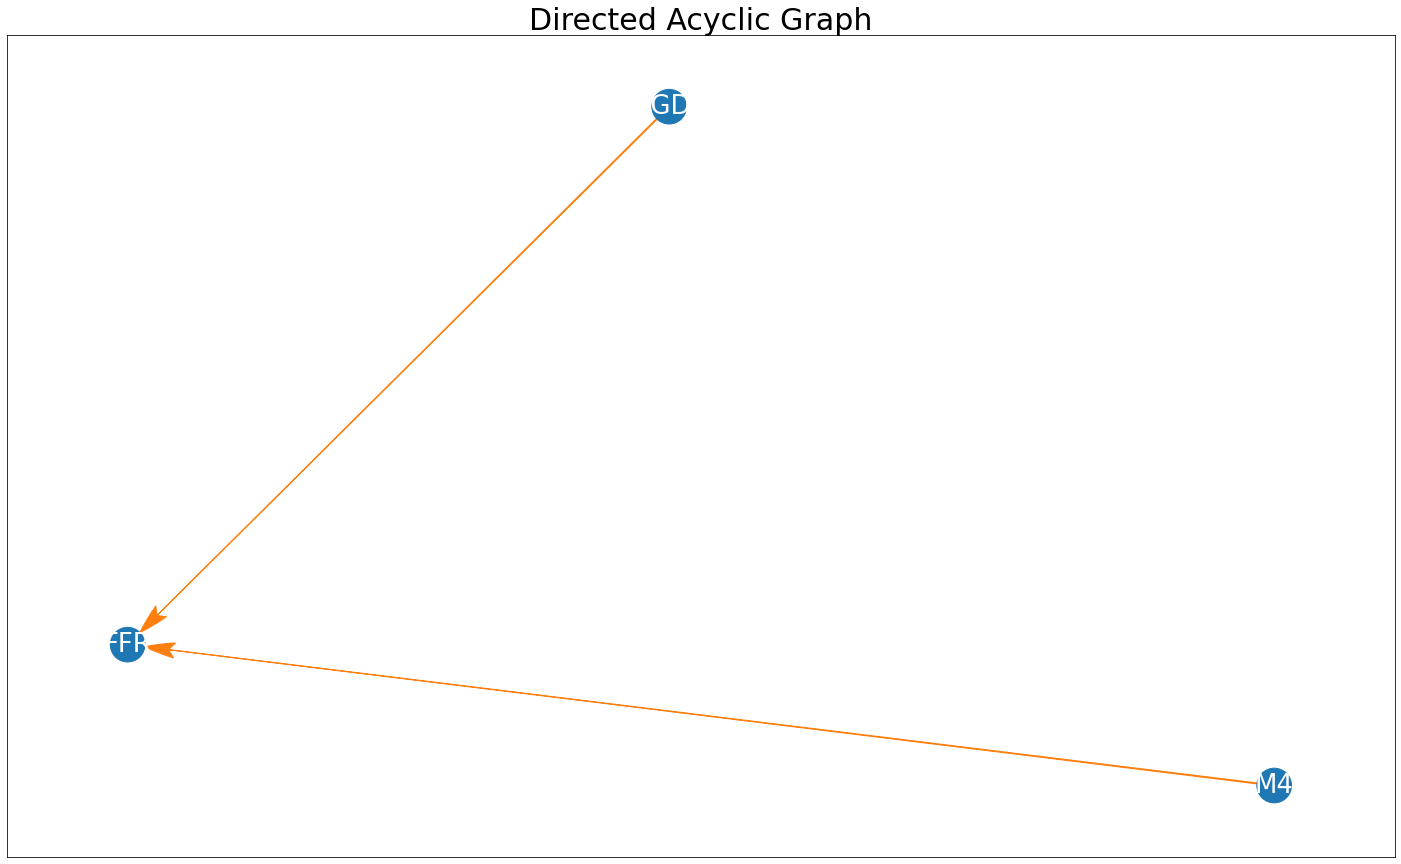

In [19]:
from matplotlib.patches import ArrowStyle

def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)

graph_DAG(edges, df, title = "Directed Acyclic Graph")
edges

keep control: M4
('NGDP', 'FFR') ['M4']
keep control: NGDP
('M4', 'FFR') ['NGDP']


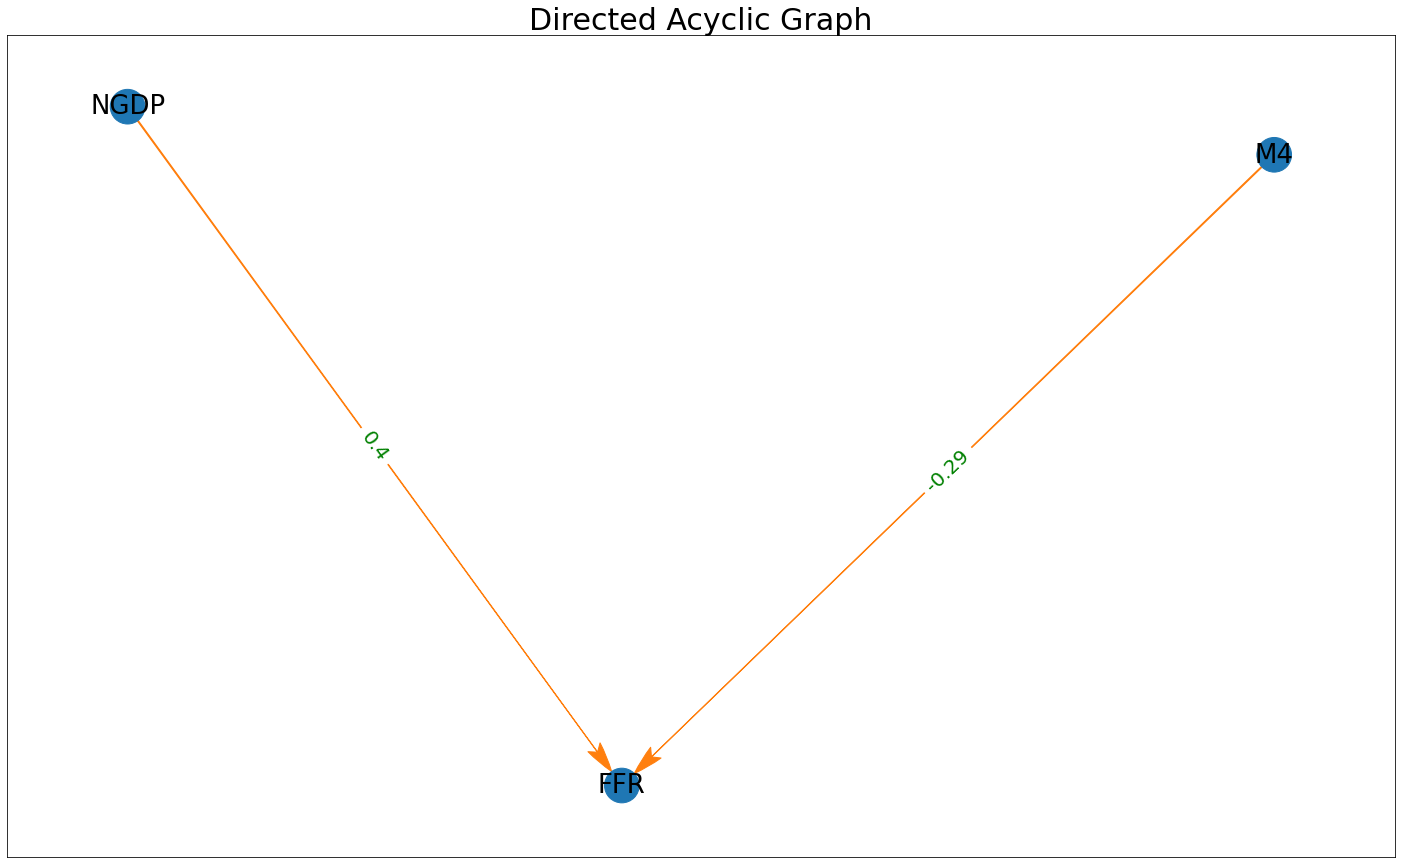

In [20]:
## D-separation

def graph_DAG(edges, df, title = ""):
    graph = nx.DiGraph()
    edge_labels = {}
    ############ Add ############
    for edge in edges:
        controls = [key for key in df.keys() if key not in edge]
        controls = list(set(controls))
        keep_controls = []
        for control in controls:
            control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
            if (control, edge[1]) in control_edges:
                print("keep control:", control)
                keep_controls.append(control)                
        print(edge, keep_controls)
        pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#         corr_matrix_heatmap(pcorr, save_fig = False, pp = None, title = "Partial Correlation")
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     # turn text black for larger variable names in homework
                     font_color = "k",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    ############ Add ############
    nx.draw_networkx_edge_labels(graph,pos,
                                edge_labels=edge_labels,
                                font_color='green',
                                font_size=20)

graph_DAG(edges, df, title = "Directed Acyclic Graph")

In [21]:
data = df
def firstLetterWord(str, num_chars = 3):
 
    result = ""
 
    # Traverse the string.
    v = True
    for i in range(len(str)):
         
        # If it is space, set v as true.
        if (str[i] == ' '):
            v = True
 
        # Else check if v is true or not.
        # If true, copy character in output
        # string and set v as false.
        elif (str[i] != ' ' and v == True):
            result += (str[i:i+num_chars])
            v = False
 
    return result

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

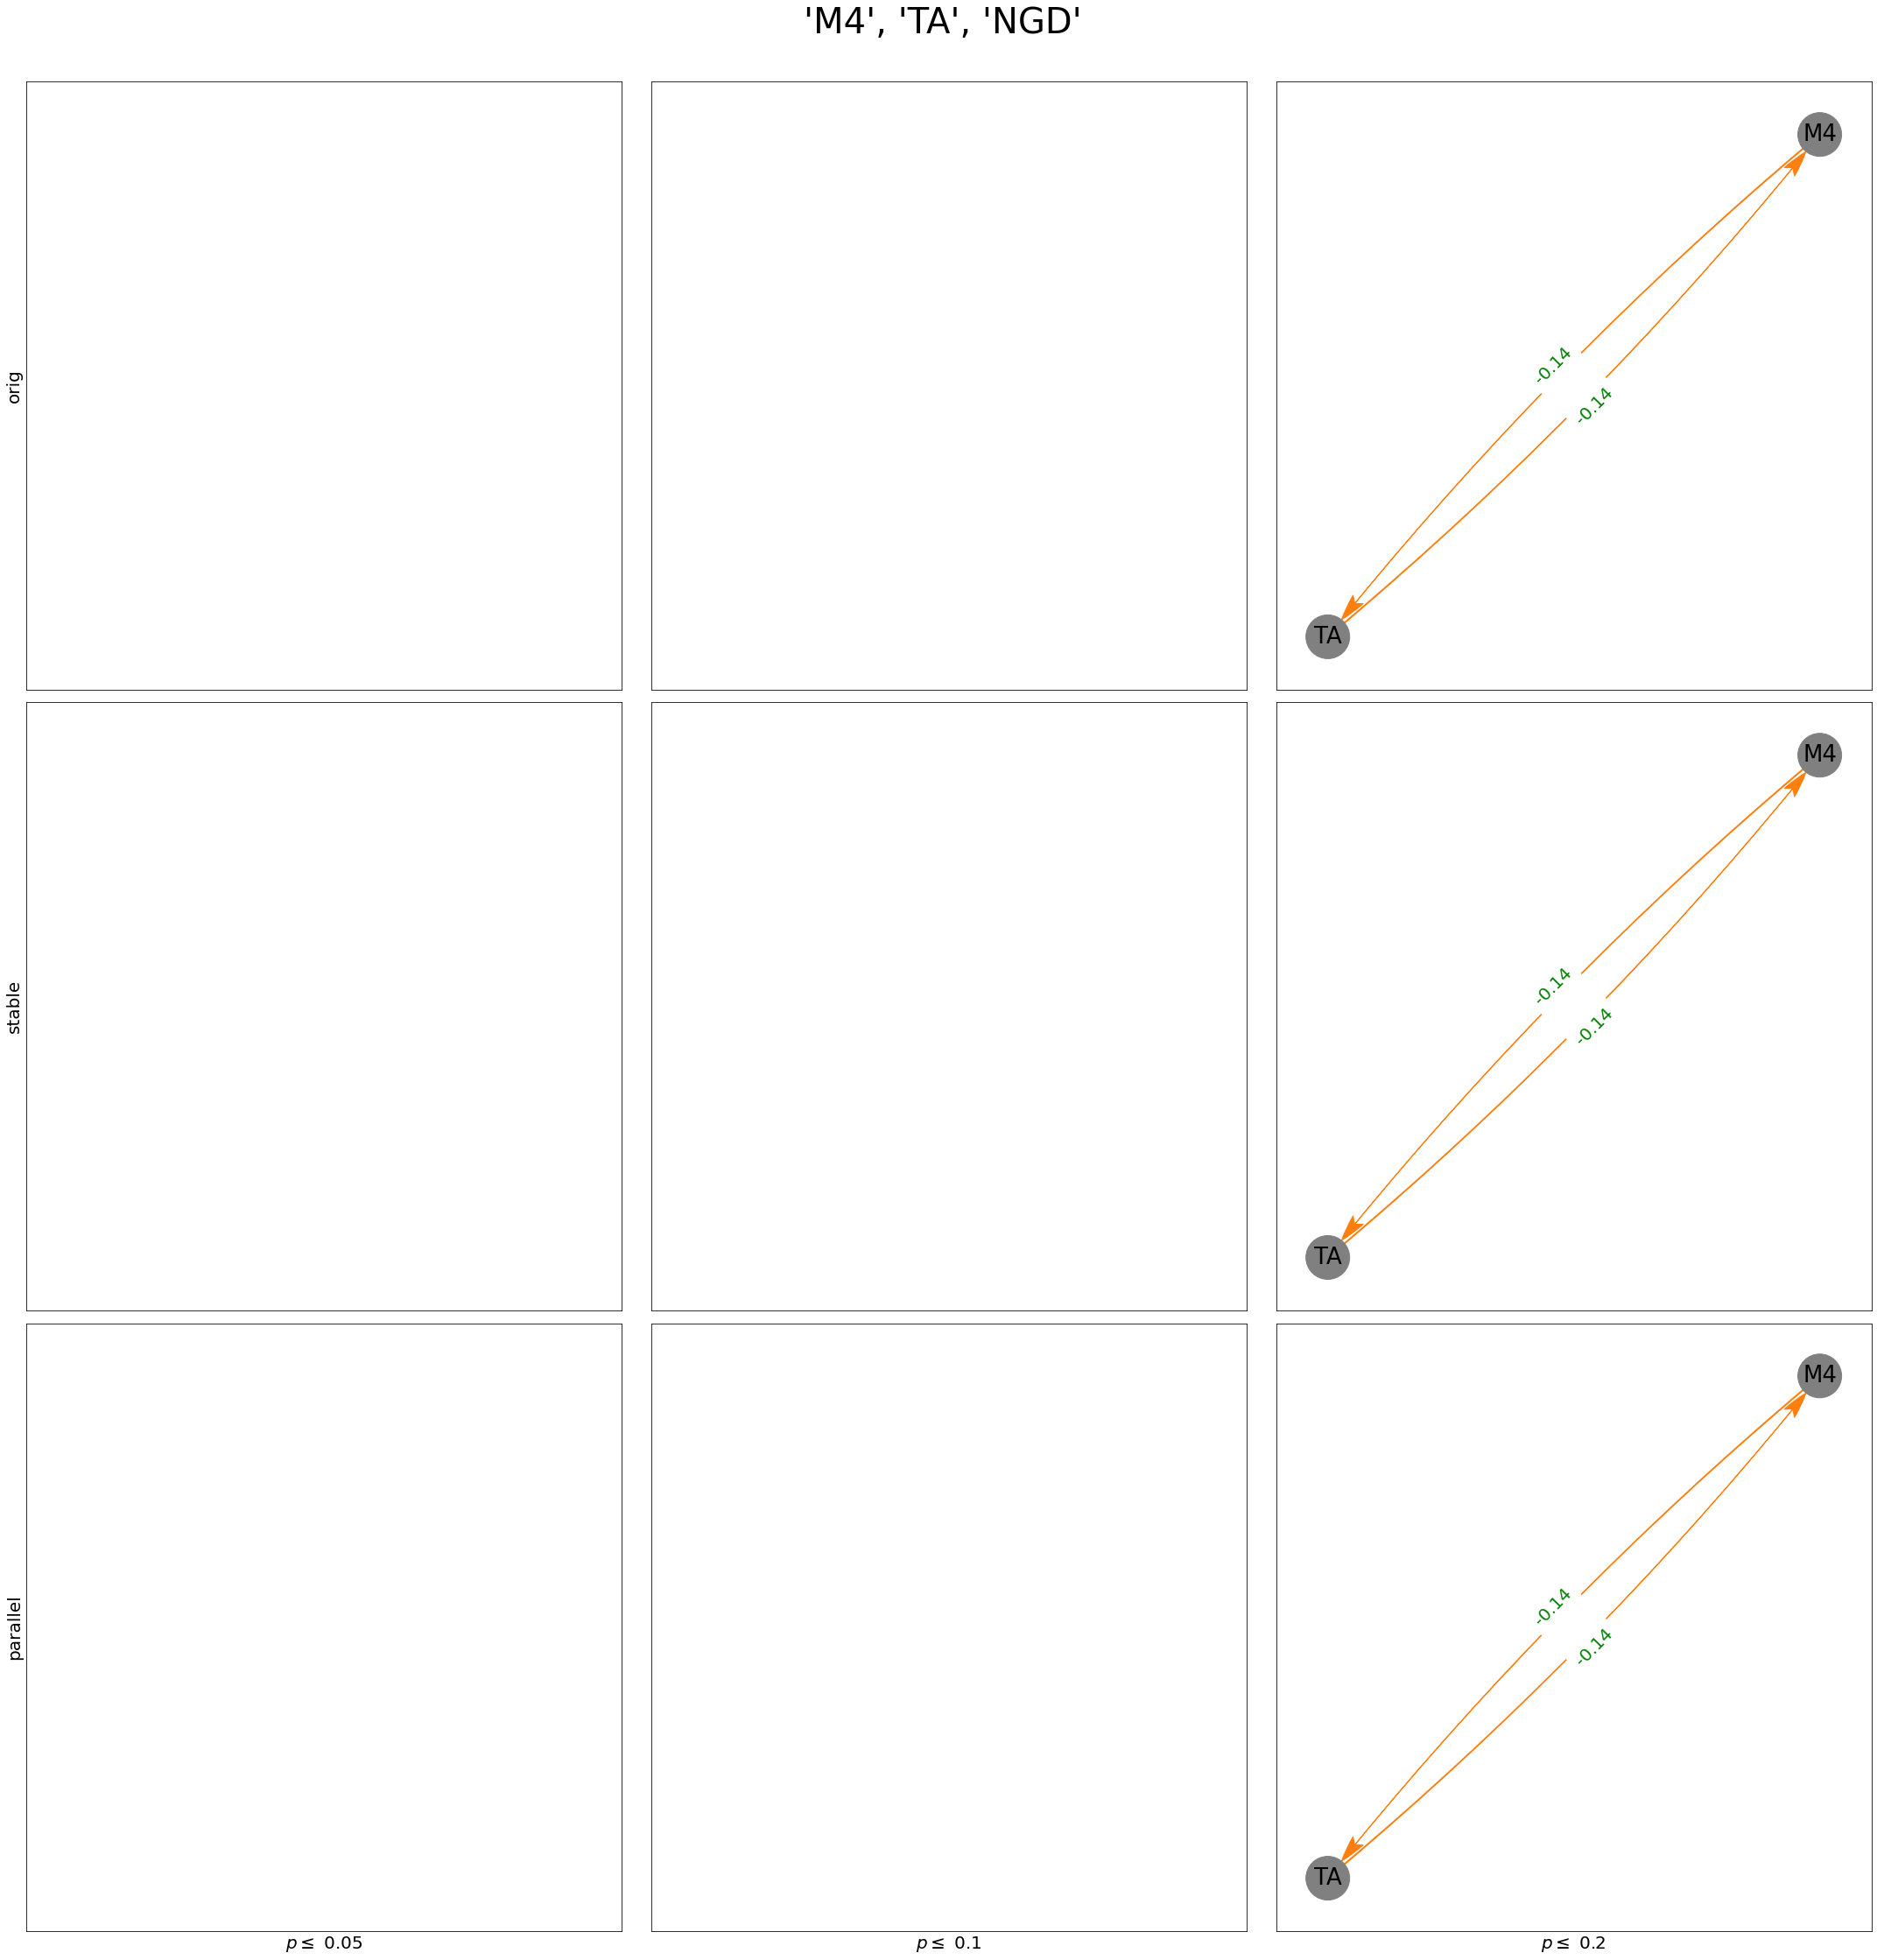

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

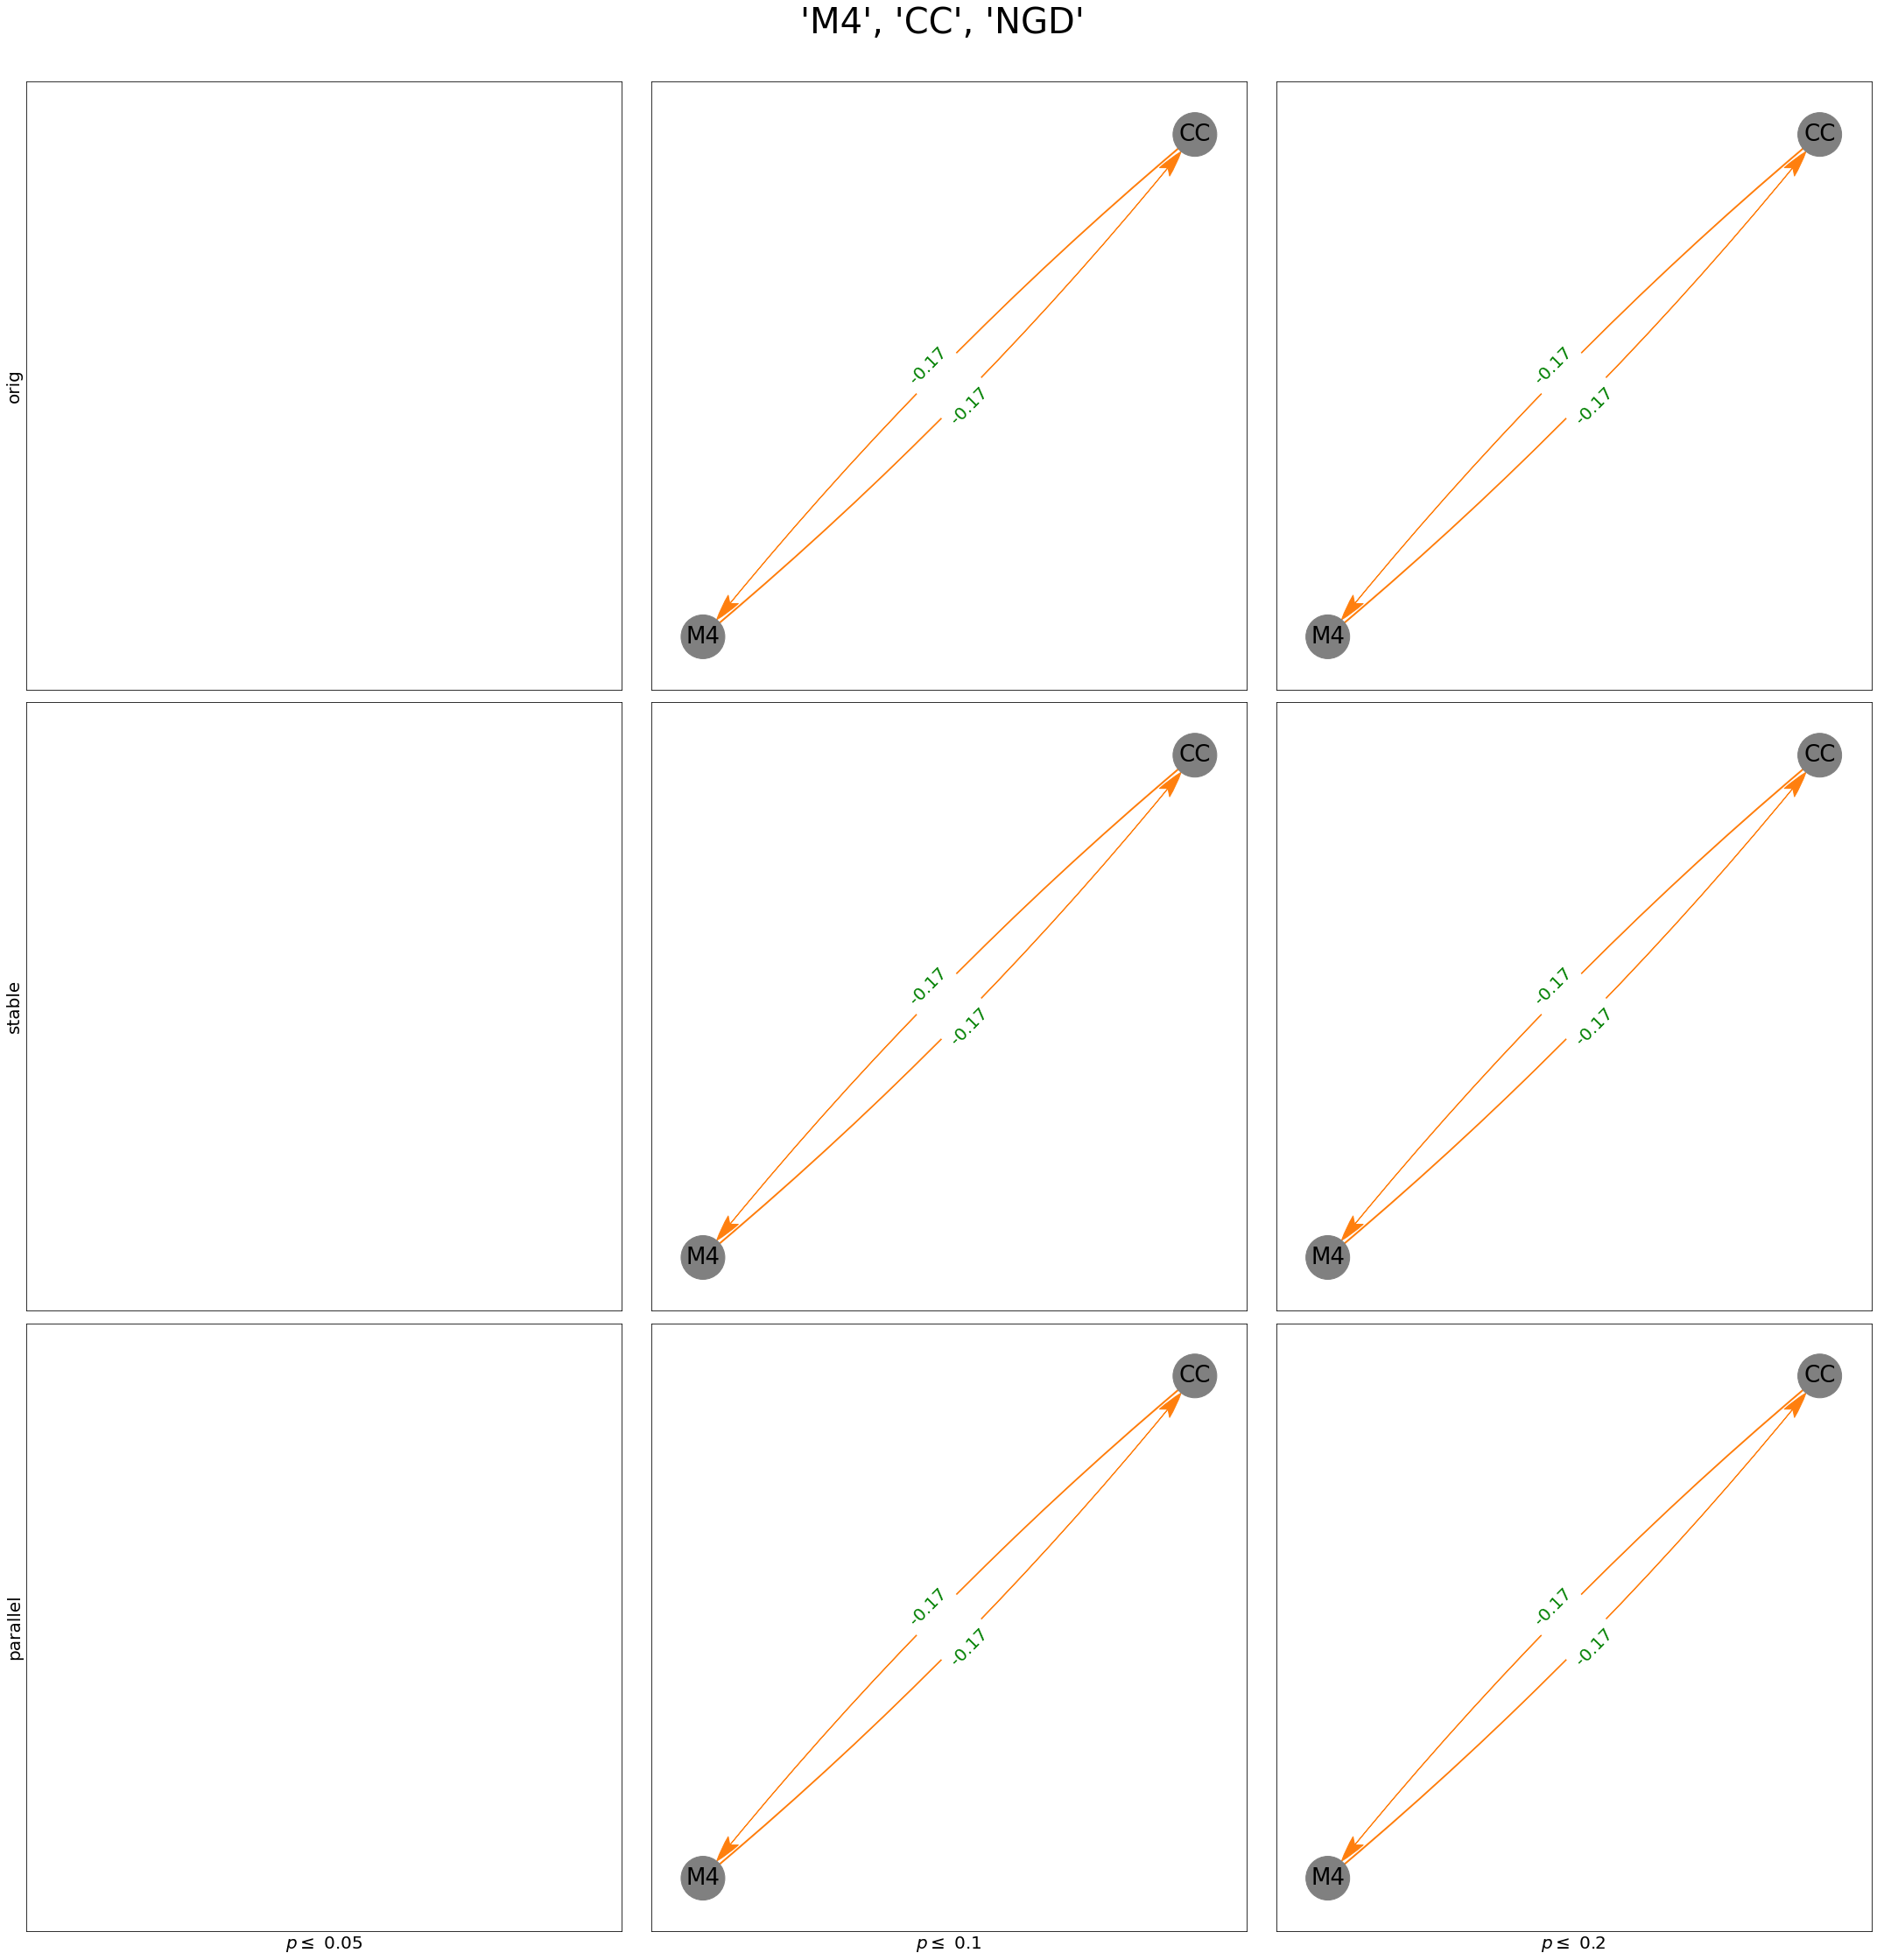

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

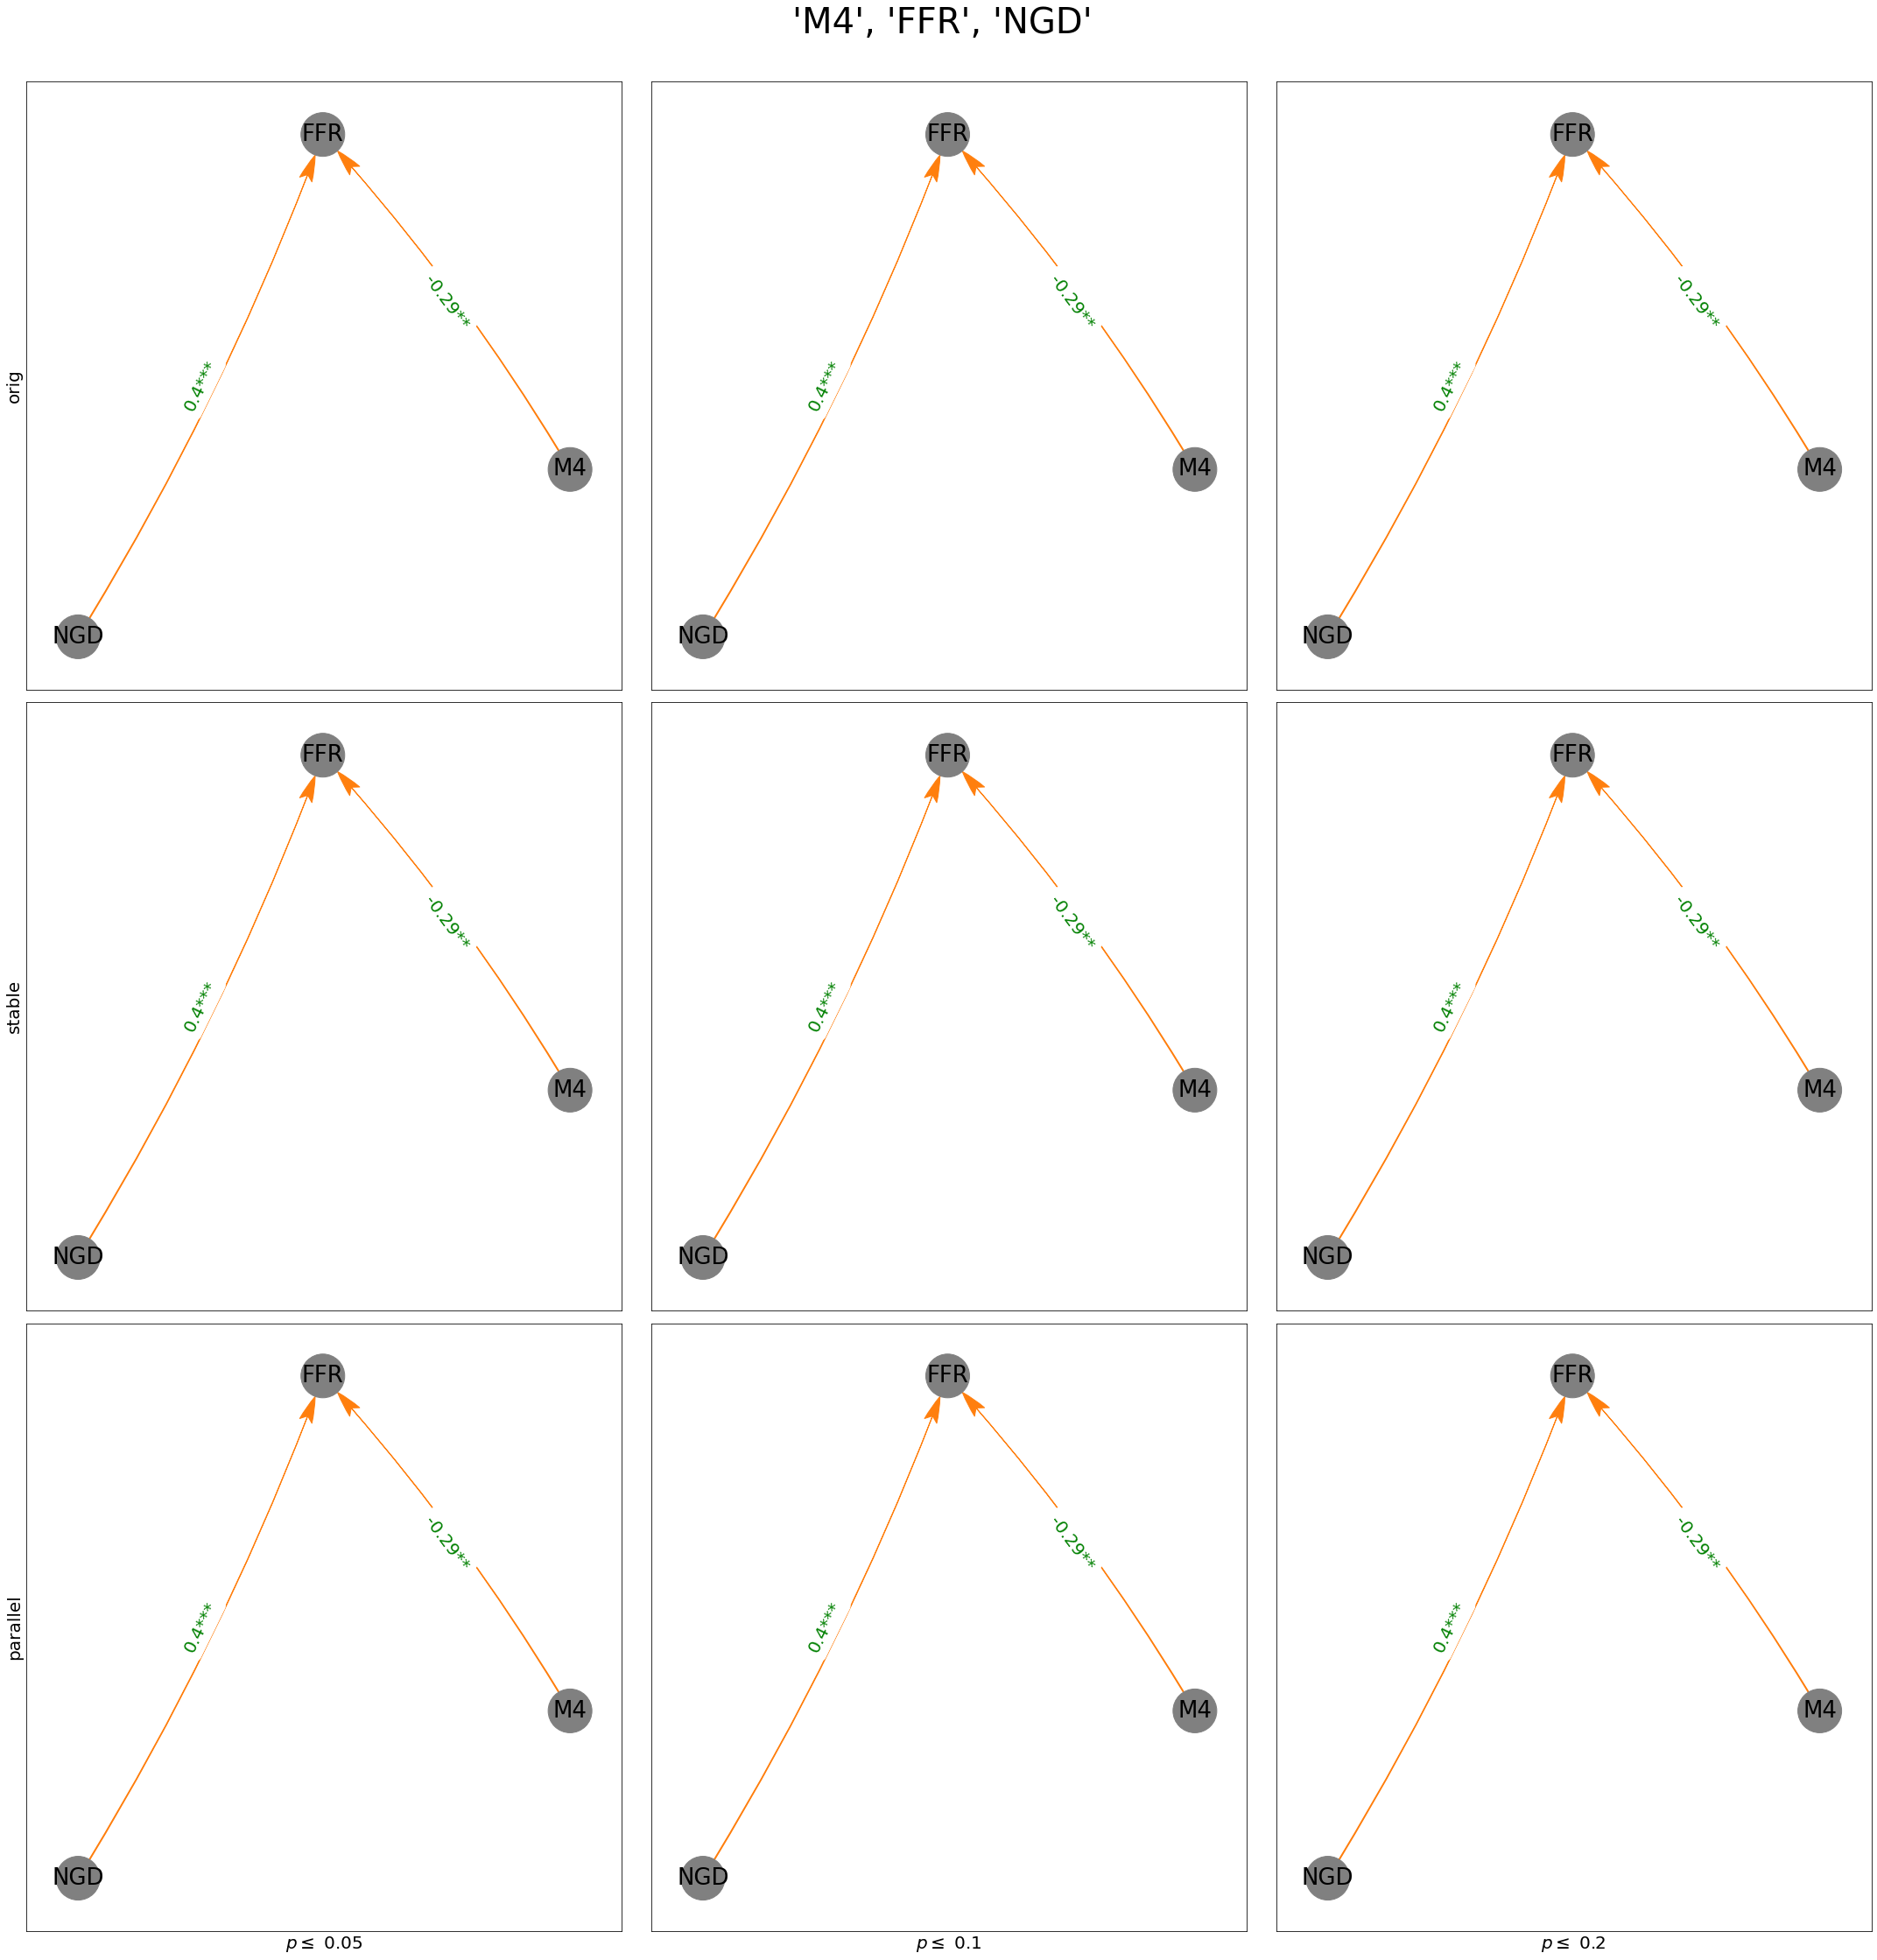

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

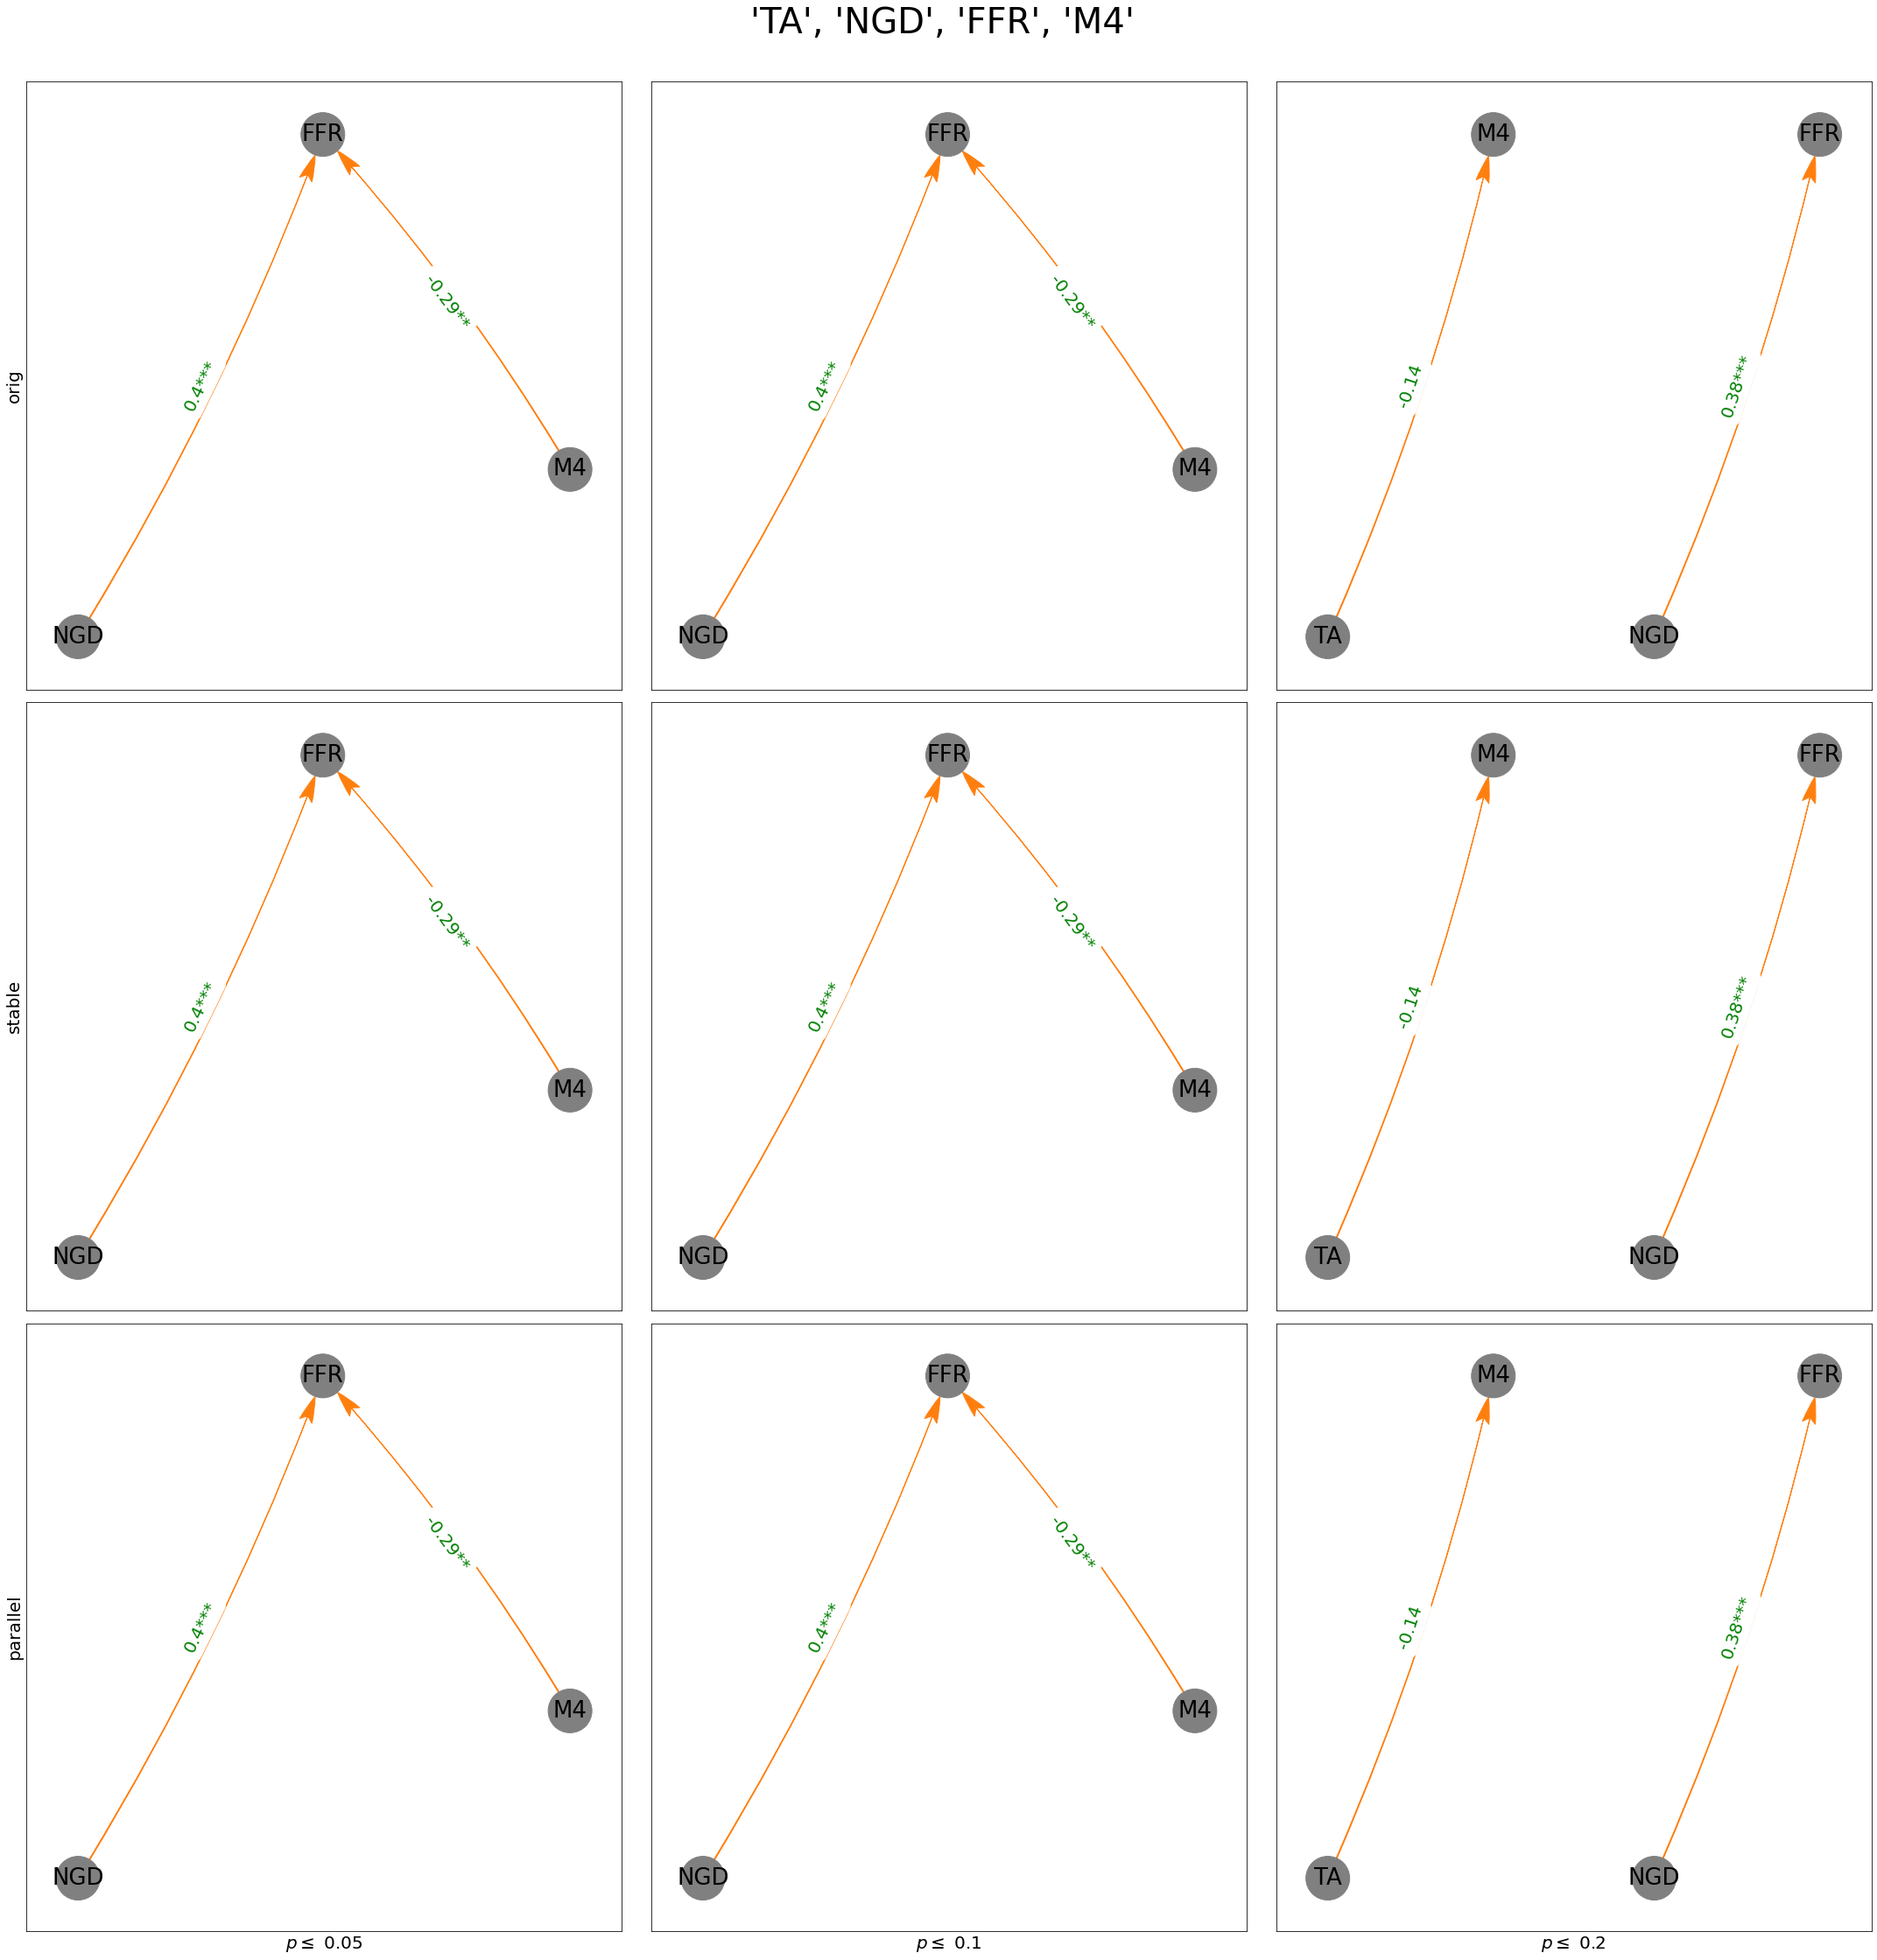

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

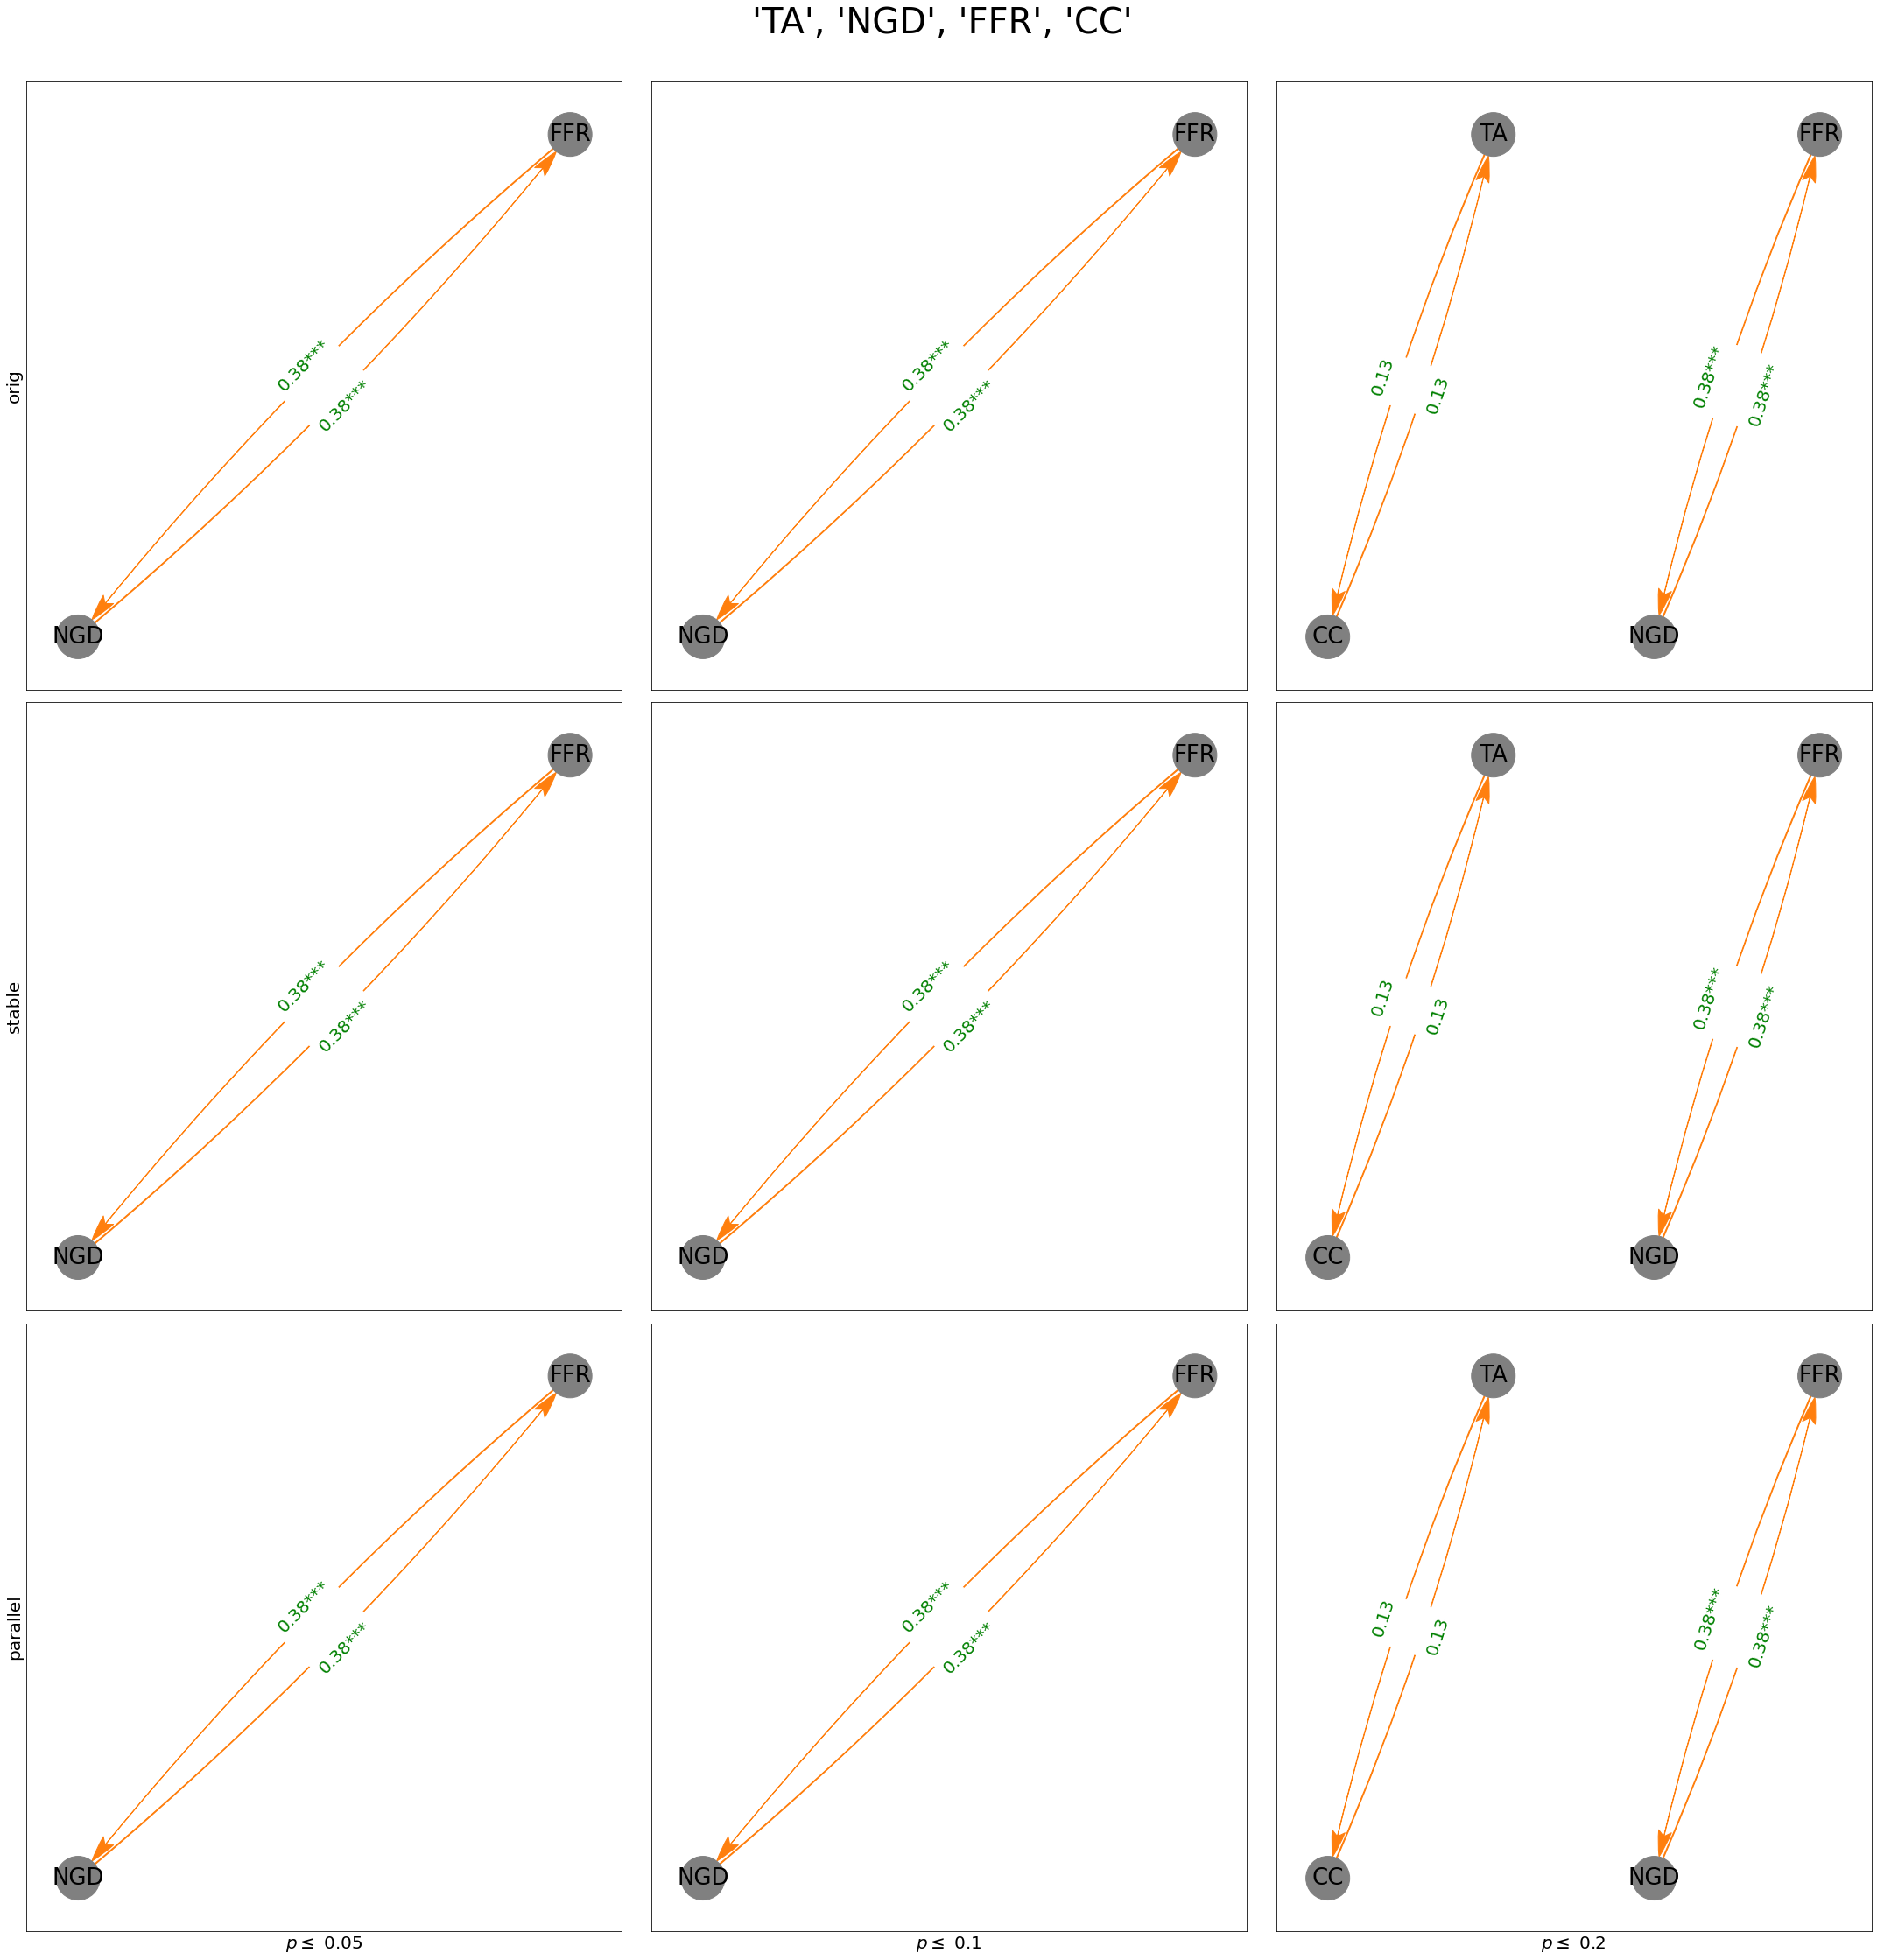

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

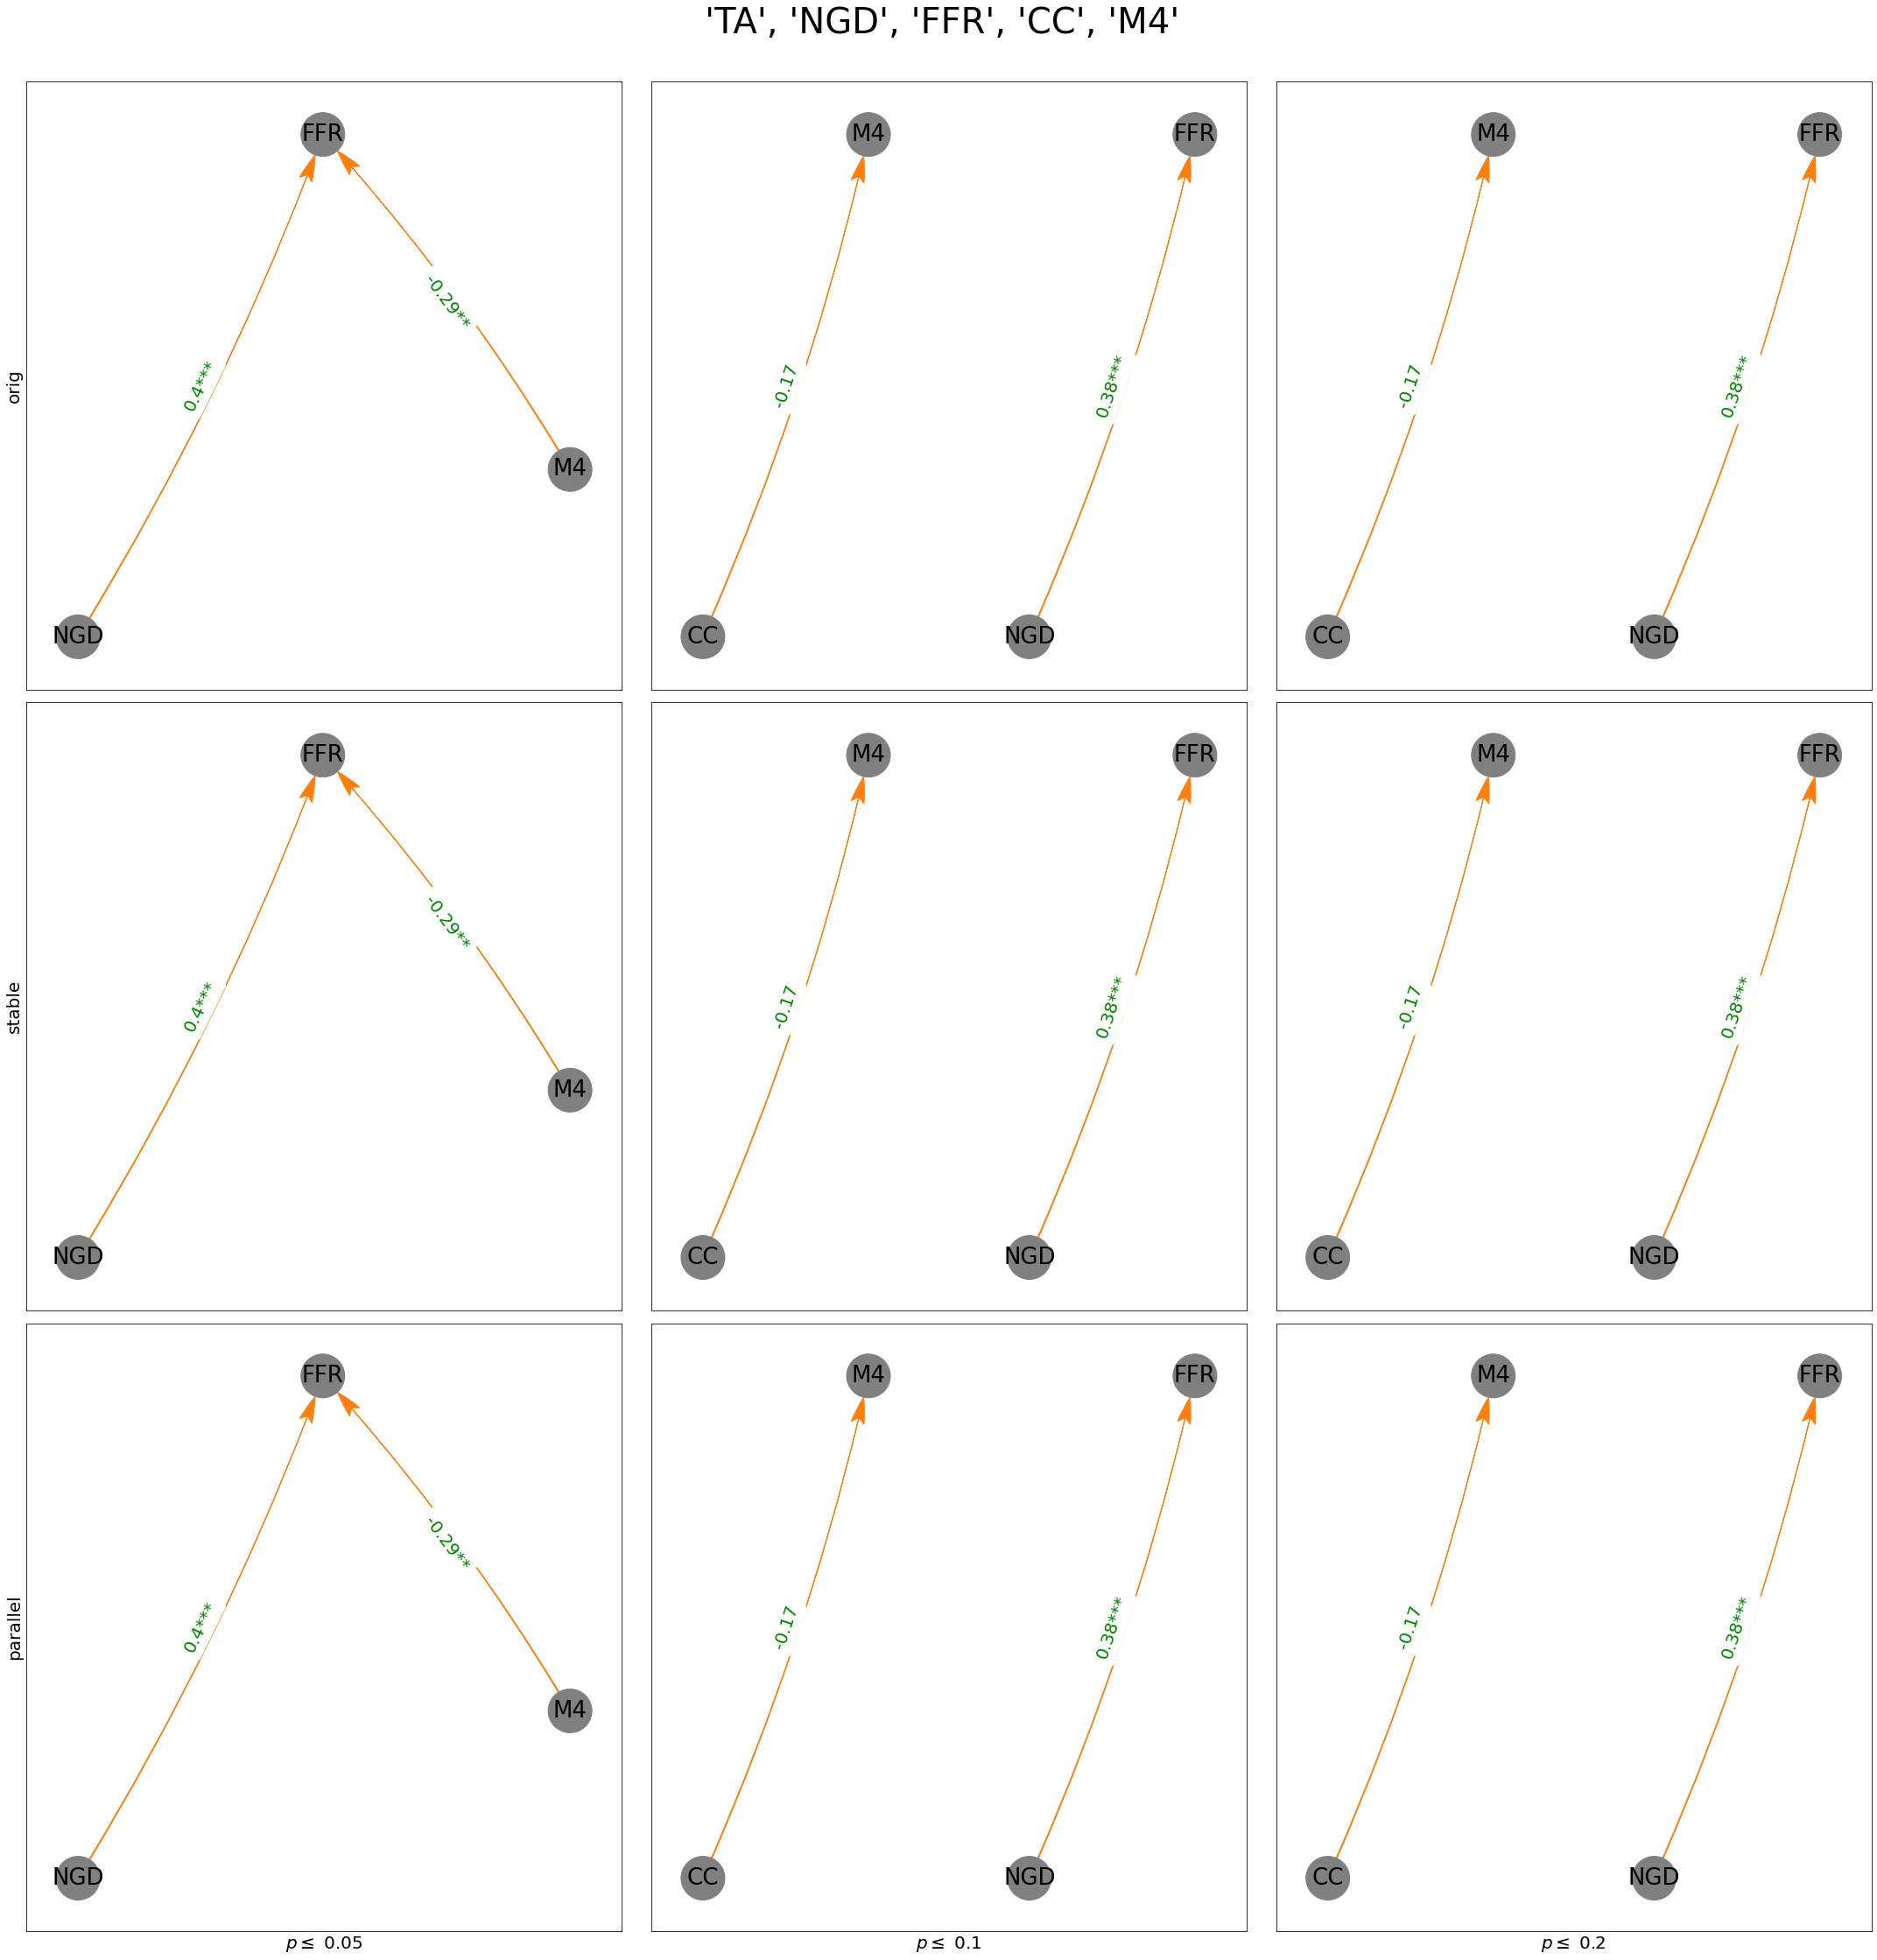

OutEdgeView([('NGD', 'FFR'), ('CC', 'M4')])

In [22]:
def graph_DAG(edges, data_reg, title = "", 
              fig = False, ax = False, 
              edge_labels = False,sig_vals = [0.05, 0.01, 0.001]):
    pcorr = data_reg.pcorr()
    graph = nx.DiGraph()
    def build_edge_labels(edges, df, sig_vals):
        edge_labels = {}
        for edge in edges:
            controls = [key for key in df.keys() if key not in edge]
            controls = list(set(controls))
            keep_controls = []
            for control in controls:
                control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
                if (control, edge[1]) in control_edges:
                    keep_controls.append(control)                
#             print(edge, keep_controls)
            pcorr = df.partial_corr(x = edge[0], y = edge[1], covar=keep_controls,
                                  method = "pearson")
            label = str(round(pcorr["r"][0],2))
            pvalue = pcorr["p-val"][0]
#             pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#             label = pcorr[edge[0]].loc[edge[1]]

            for sig_val in sig_vals:
                if pvalue < sig_val: 
                    label = label + "*"   
            
            edge_labels[edge] = label
        return edge_labels
    
    if edge_labels == False:
        edge_labels = build_edge_labels(edges, 
                                        data_reg, 
                                        sig_vals=sig_vals) 
    graph.add_edges_from(edges)
    color_map = ["grey" for g in graph]

    if fig == False and ax == False: fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    #pos = nx.spring_layout(graph)
    pos = graphviz_layout(graph)

    edge_labels2 = []
    for u, v, d in graph.edges(data=True):
        if pos[u][0] > pos[v][0]:  
            if (v,u) in edge_labels.keys():
                edge_labels2.append(((u, v,), f'{edge_labels[u,v]}\n\n\n{edge_labels[(v,u)]}'))  
        if (v,u) not in edge_labels.keys():
            edge_labels2.append(((u,v,), f'{edge_labels[(u,v)]}'))
    edge_labels = dict(edge_labels2)

    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 2500,
                     with_labels=True,  arrows=True,
                     font_color = "black",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                     connectionstyle='arc3, rad = 0.05',
                     ax = a)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20,
                                ax = a)
    

DAG_models_vars = {0:["M4", "TA", "NGDP"],
                  1:["M4", "CC", "NGDP"],
                  2:["M4", "FFR", "NGDP"],
                  3:["TA", "NGDP", "FFR", "M4"],
                  4:["TA", "NGDP", "FFR", "CC"],
                  5:["TA", "NGDP", "FFR", "CC","M4"]}
# link_sigs = [0.05, 0.1, 0.2]
link_sigs = [0.05, .1, .2]
algorithms = ["orig", "stable", "parallel"]
for keys in DAG_models_vars.values():
    fig, ax = plt.subplots(len(algorithms), len(link_sigs), figsize = (30,30))
    max_cond_vars = len(keys) - 2
    data_reg = data[keys].dropna()
    data_reg.rename(columns = {col:firstLetterWord(col) for col in keys}, inplace = True)
    keys = data_reg.keys()
    c = PC(data_reg[keys].dropna())
    max_cond_vars = len(keys) - 2
    i,j = 0,0
    for sig in link_sigs:
        for algorithm in algorithms:
            model = c.estimate(return_type = "pdag", variant = algorithm, 
                               significance_level = sig, 
                               max_cond_vars = max_cond_vars, ci_test = "pearsonr")
            edges = model.edges()
            pcorr = data_reg.pcorr()
            weights = {}
            a = ax[i][j]
            graph_DAG(edges, data_reg, fig = fig, ax = a)
        
            if j == 0:
                a.set_ylabel(algorithm, fontsize = 20)
            if i == len(algorithms) - 1:
                a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 20)
            i += 1
        j += 1
        i = 0
    plt.suptitle(str(list(keys)).replace("[","").replace("]",""), fontsize = 40, y =1.035)
    plt.show()
    plt.close()
edges

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

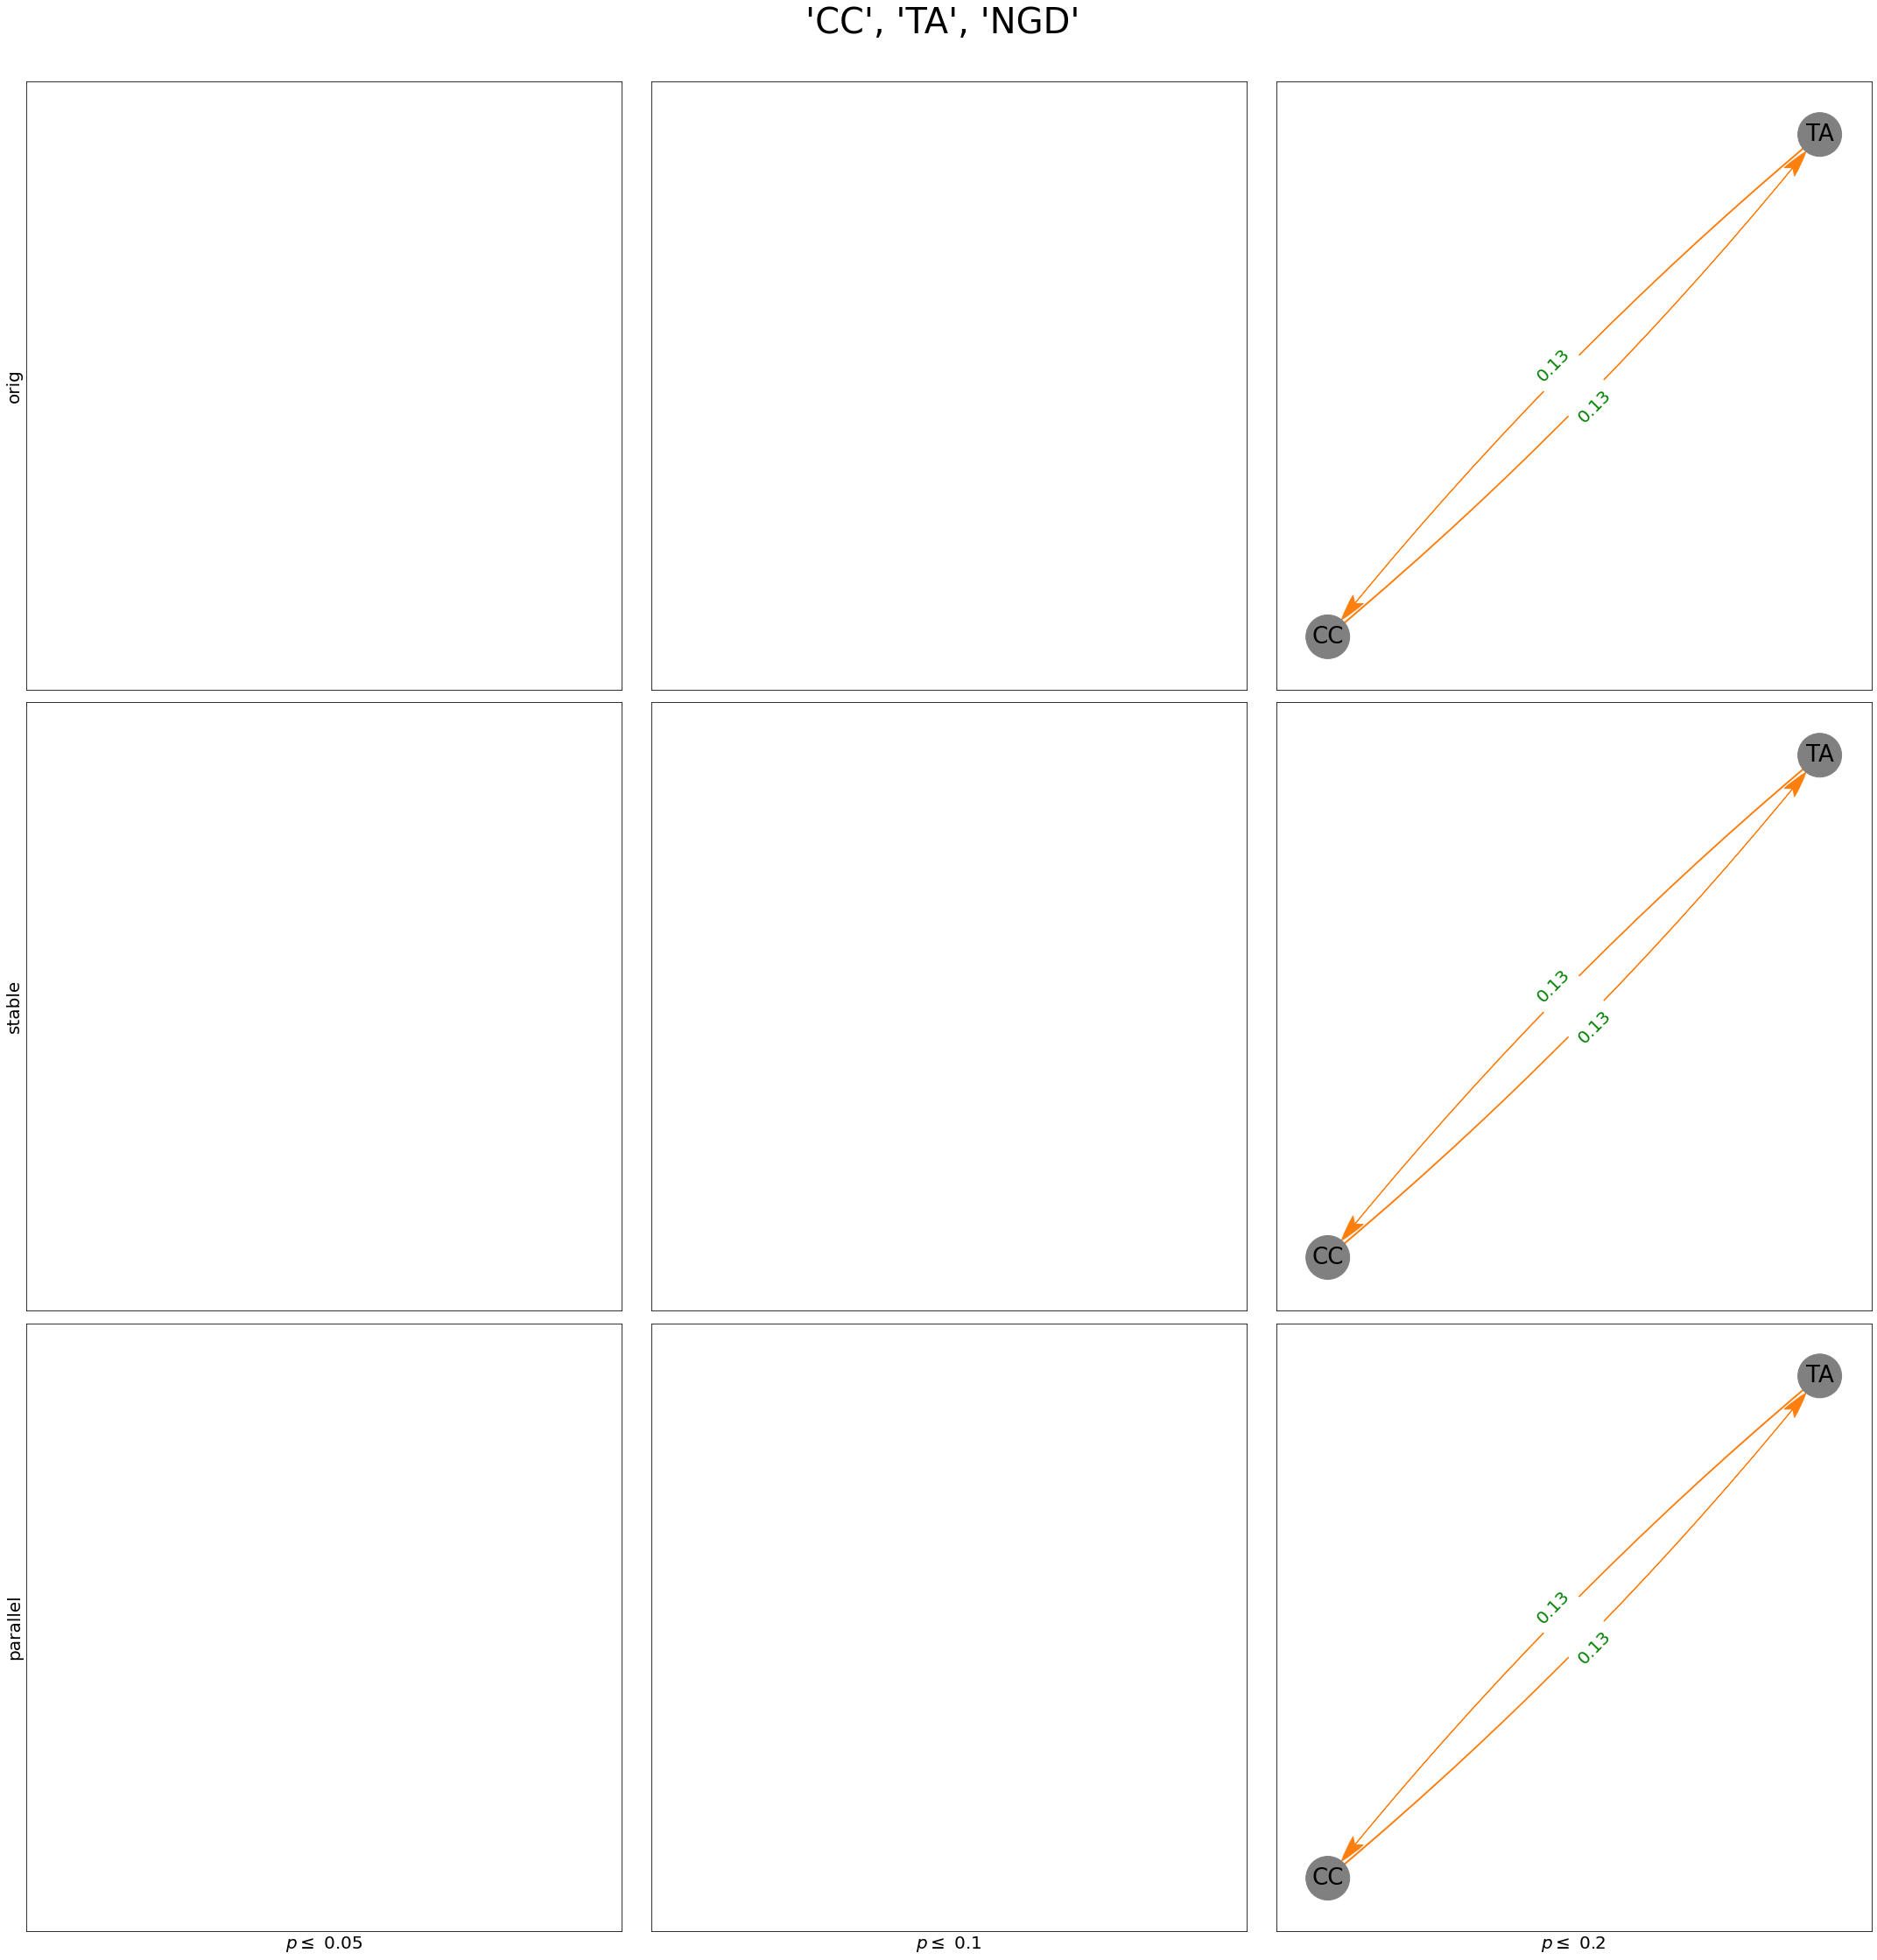

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

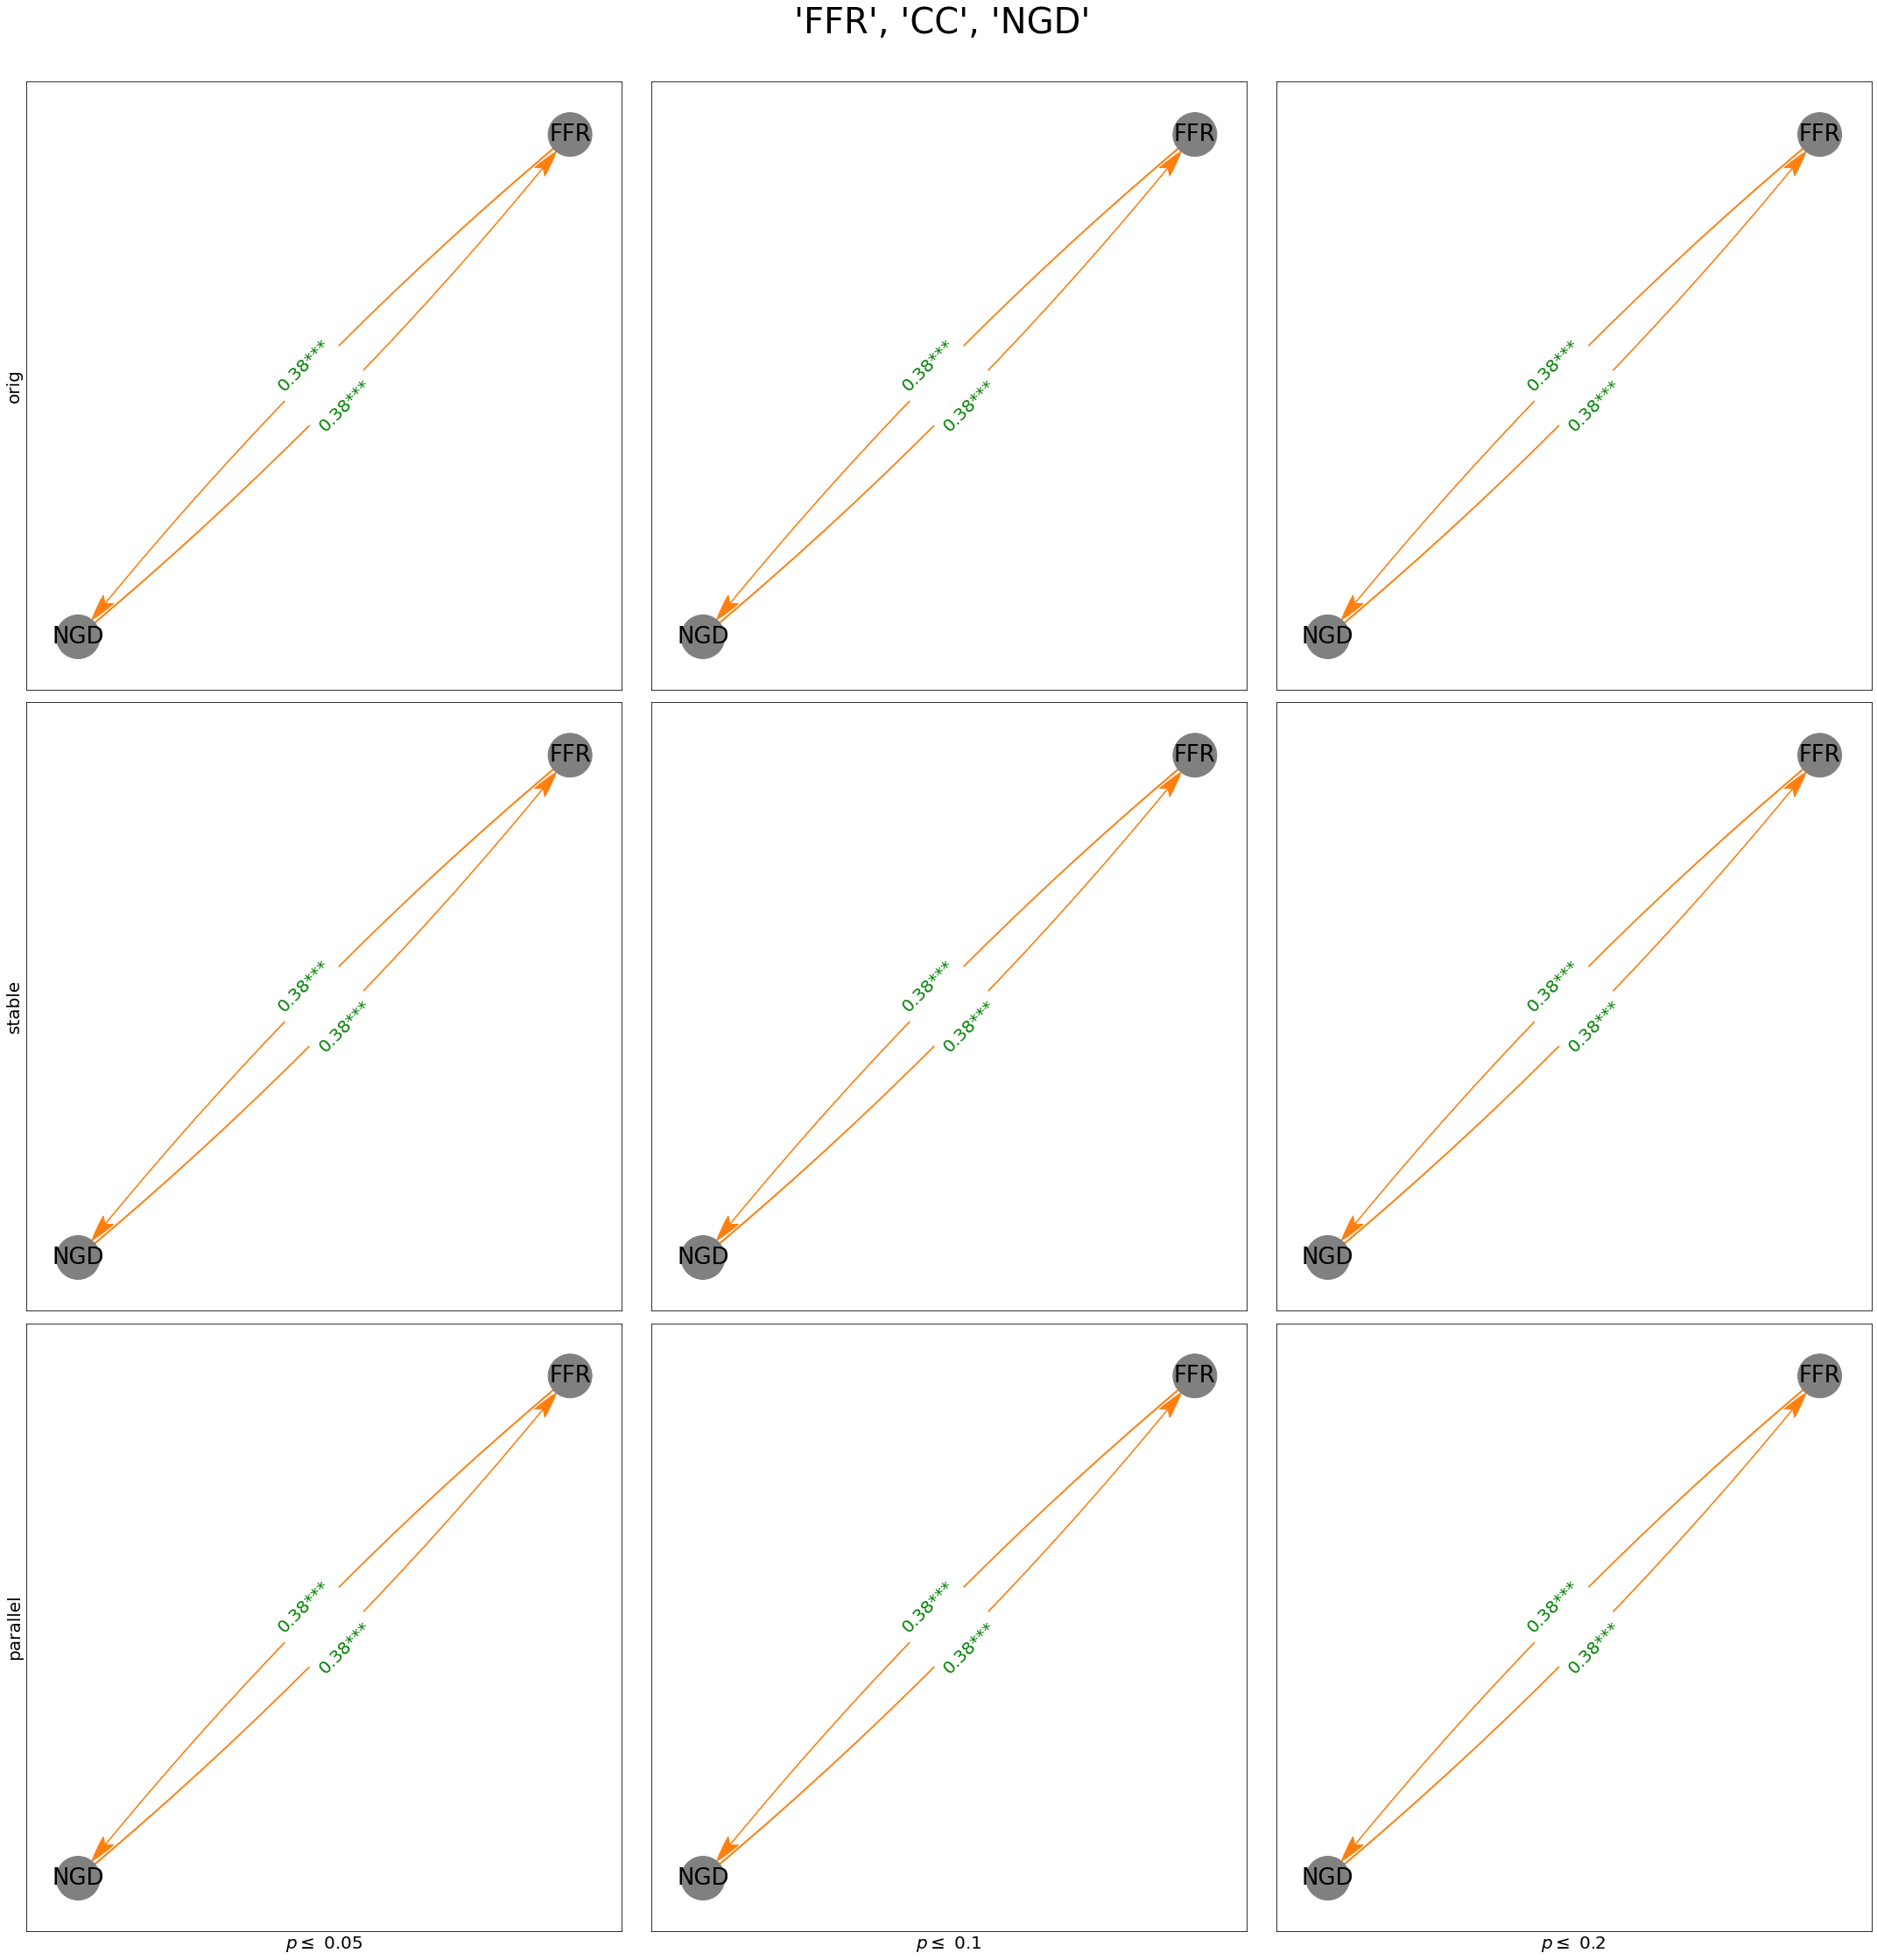

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

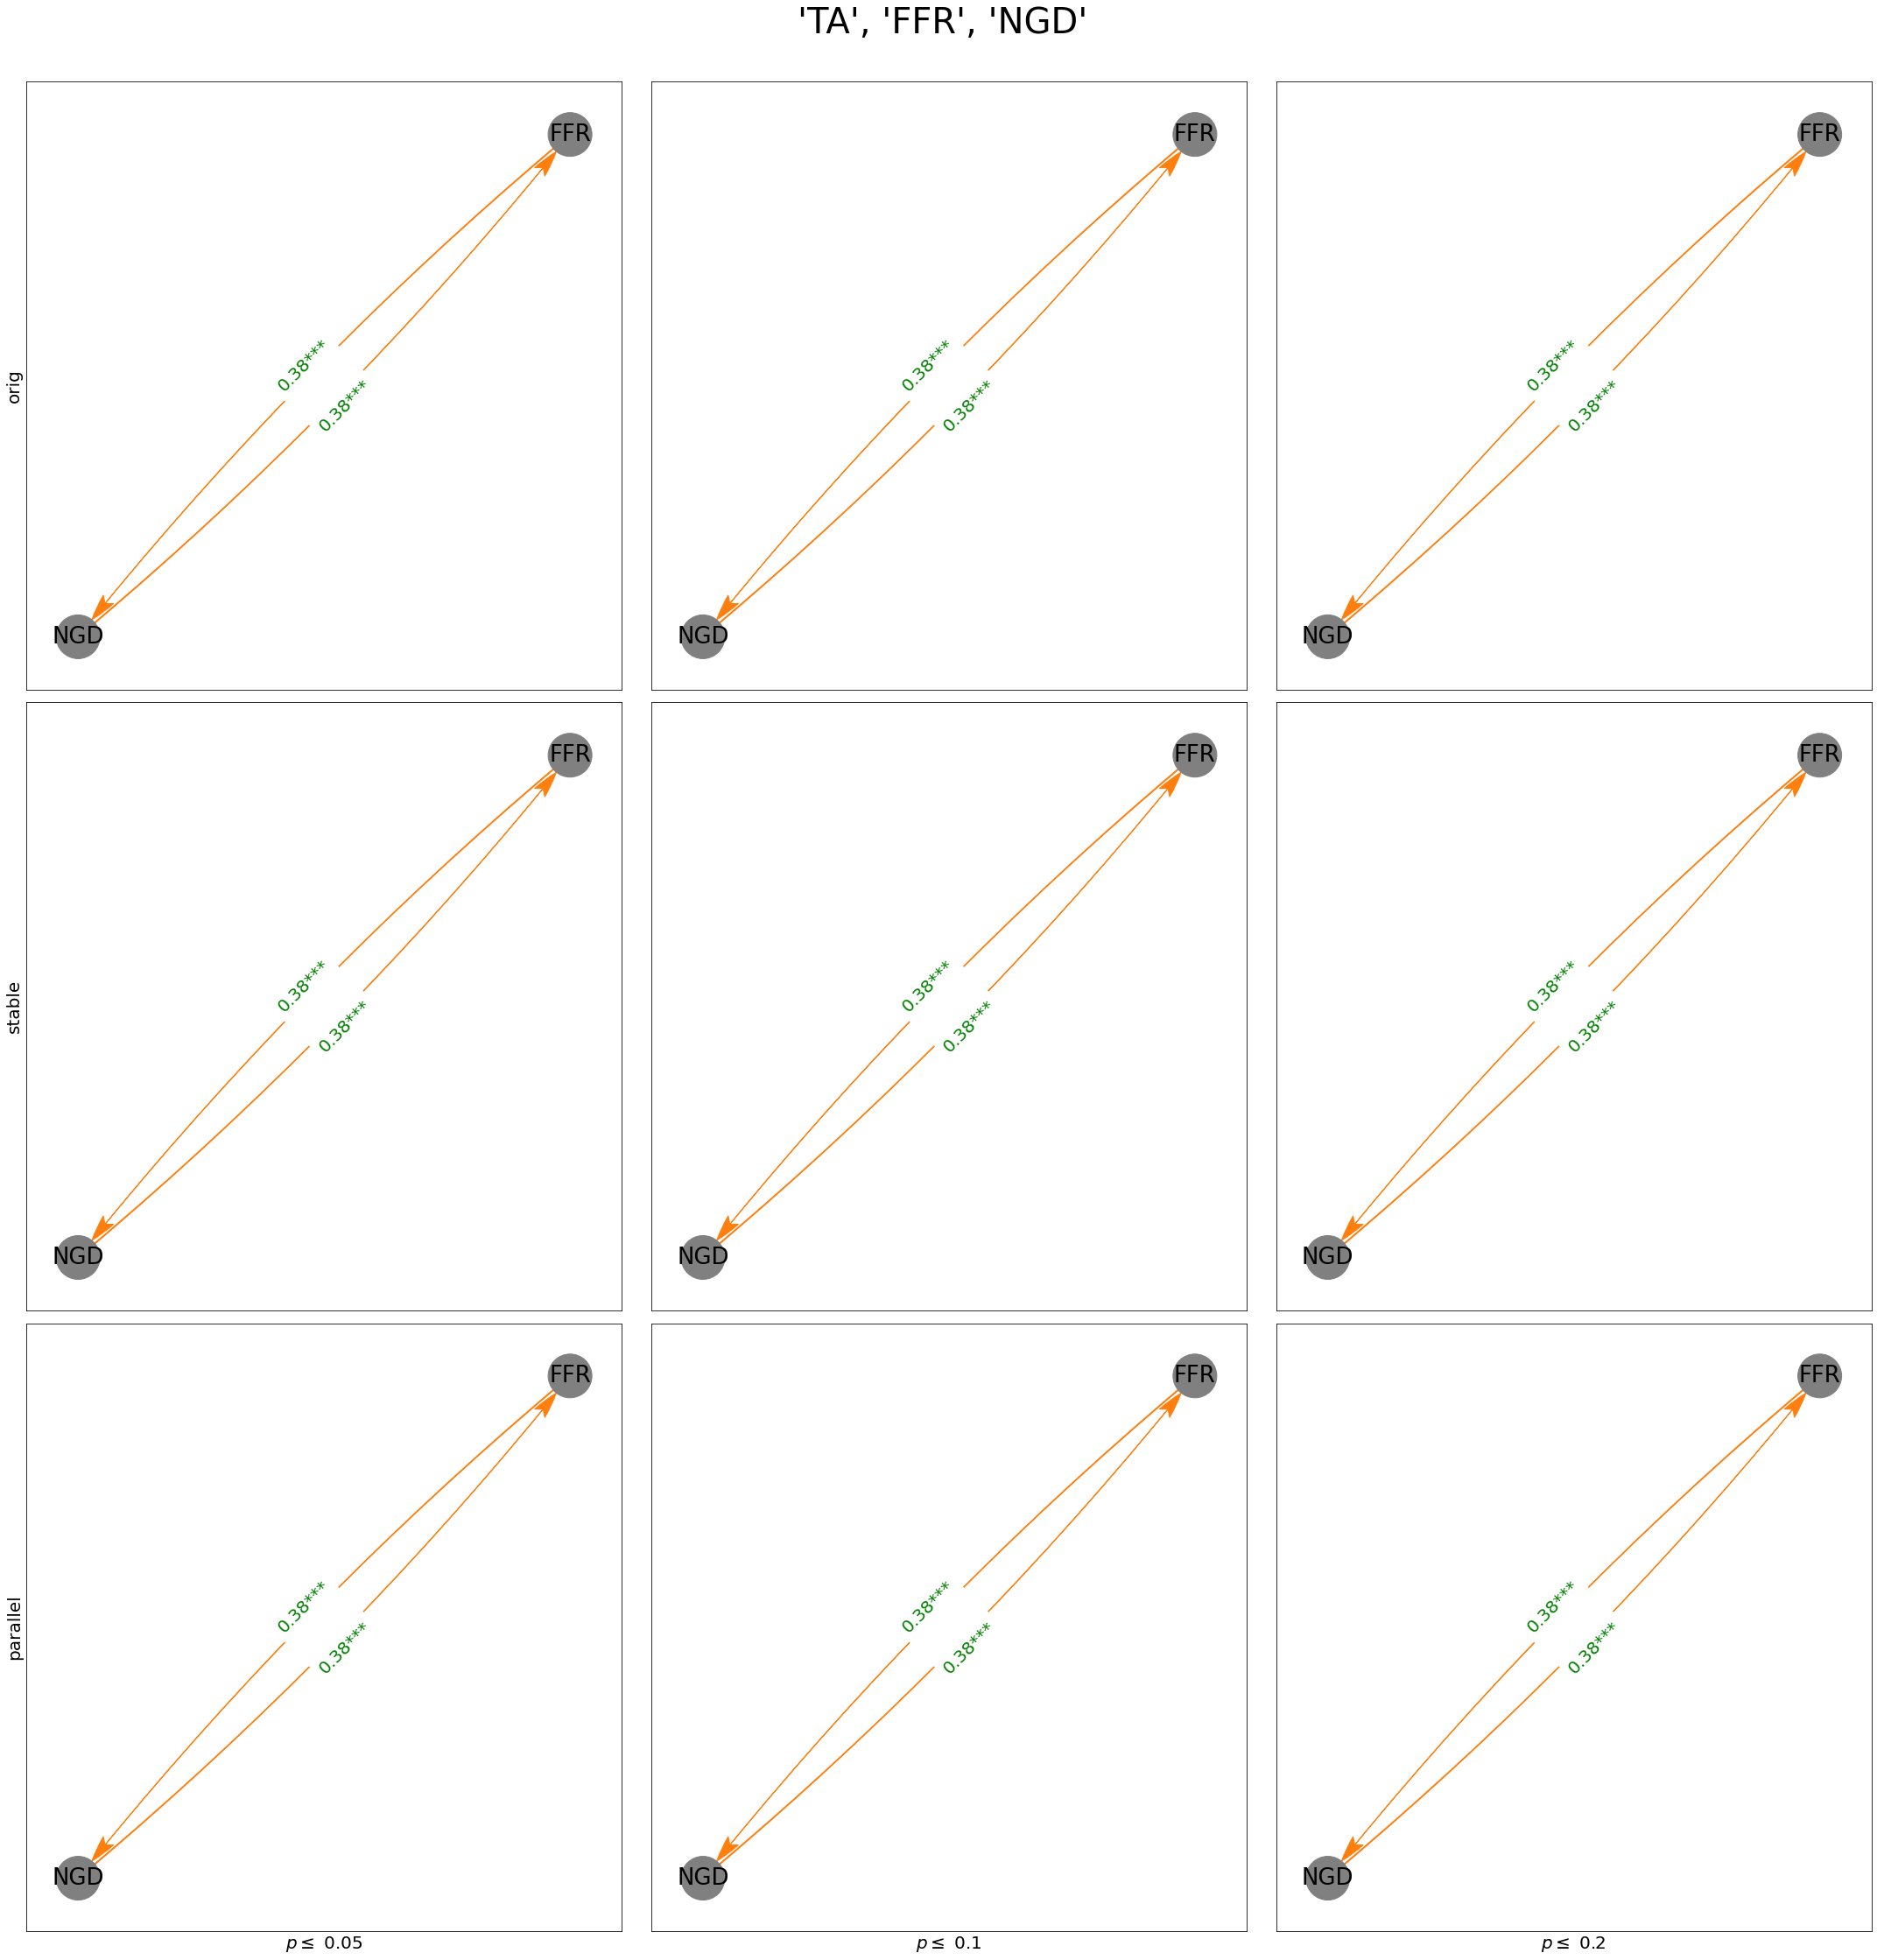

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

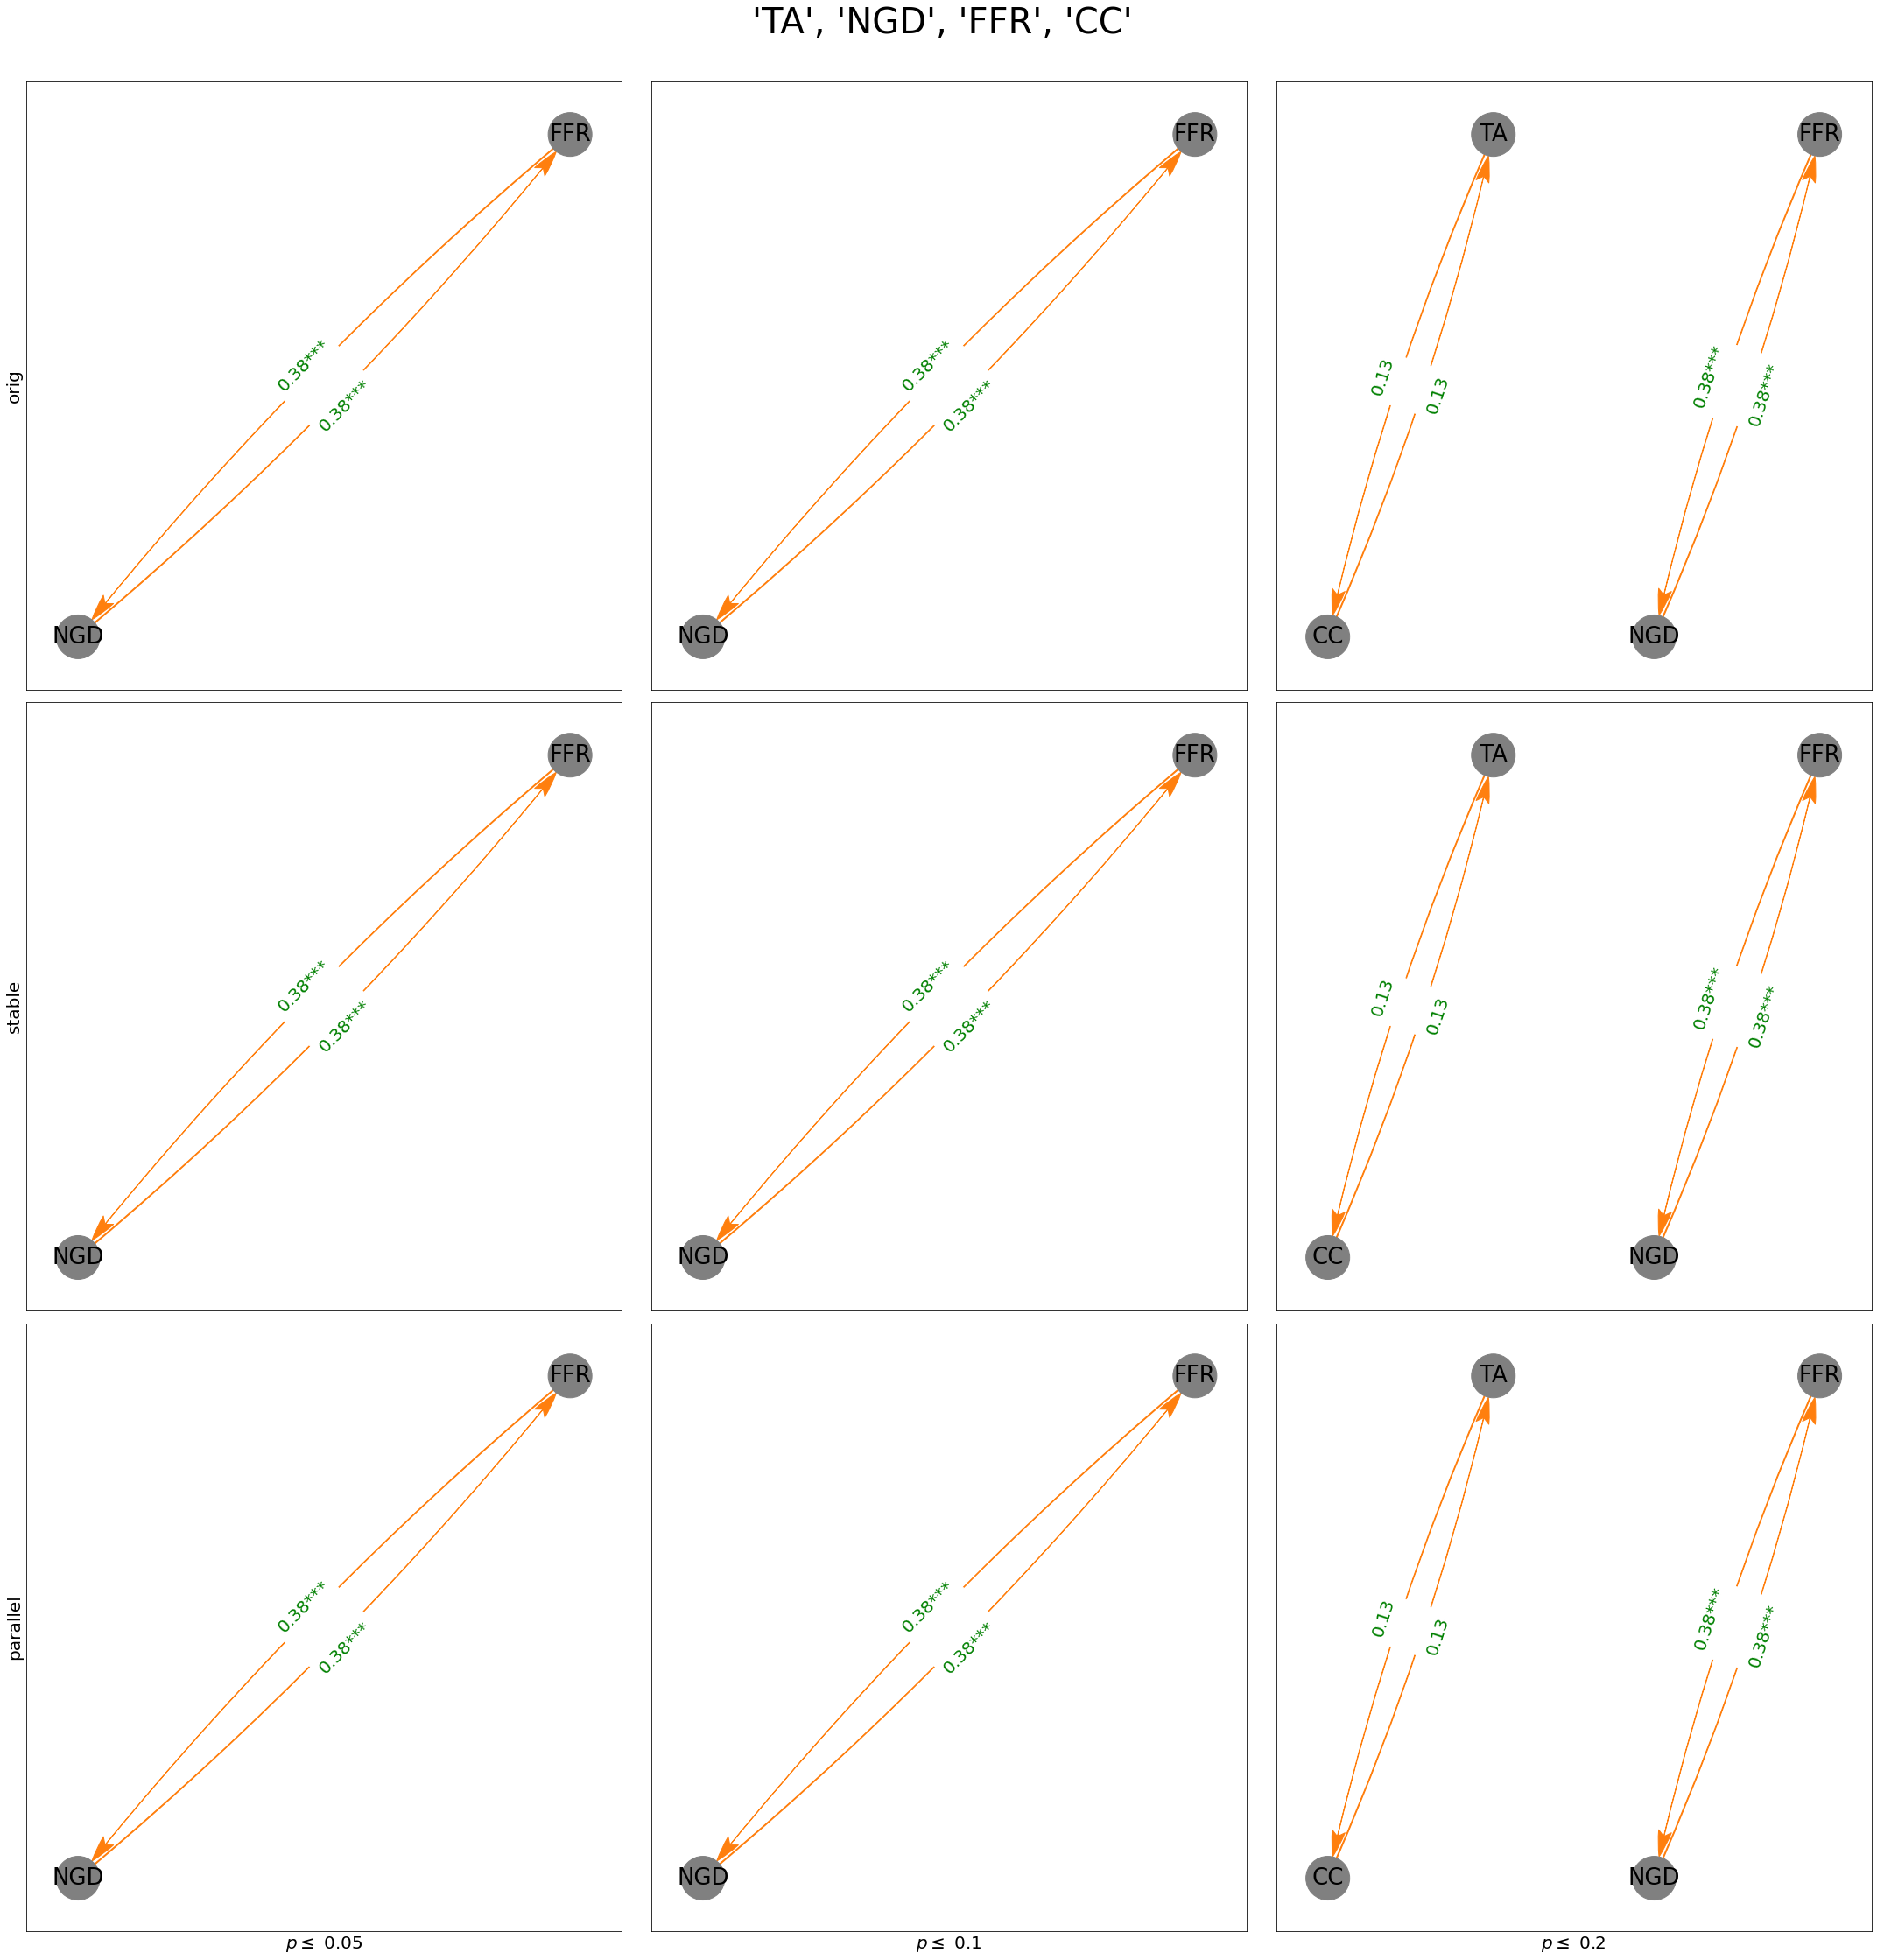

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

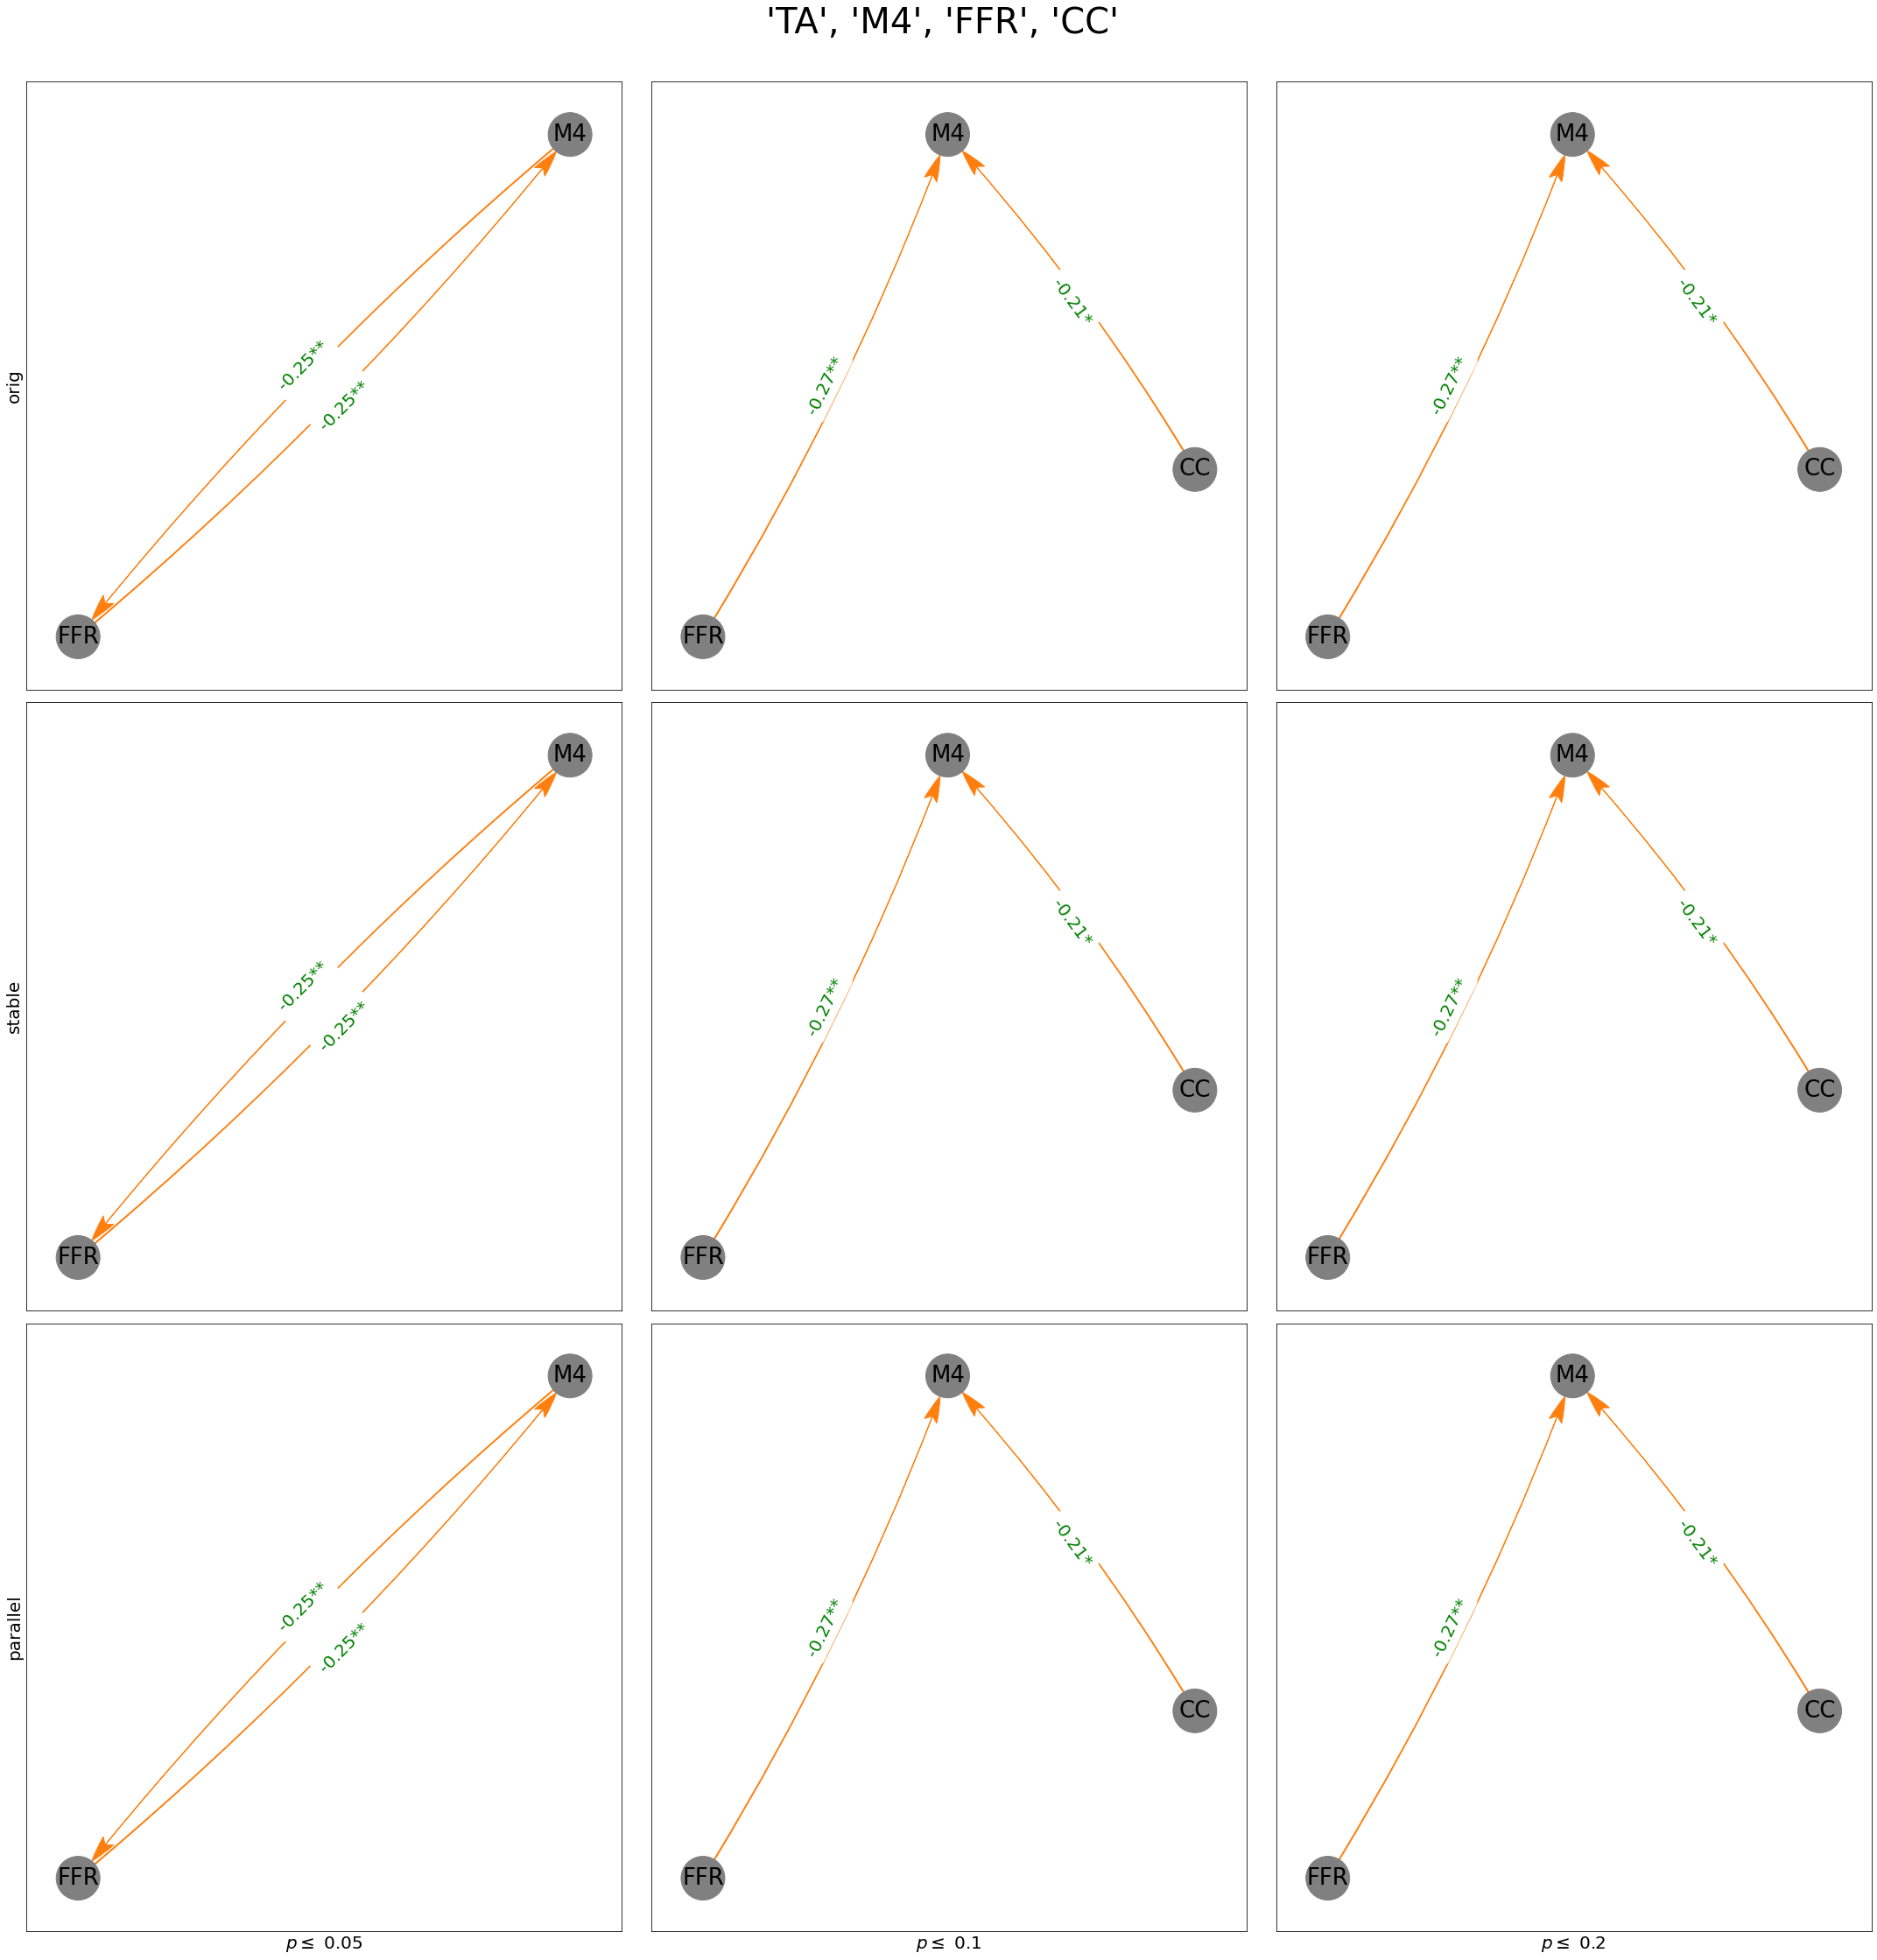

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

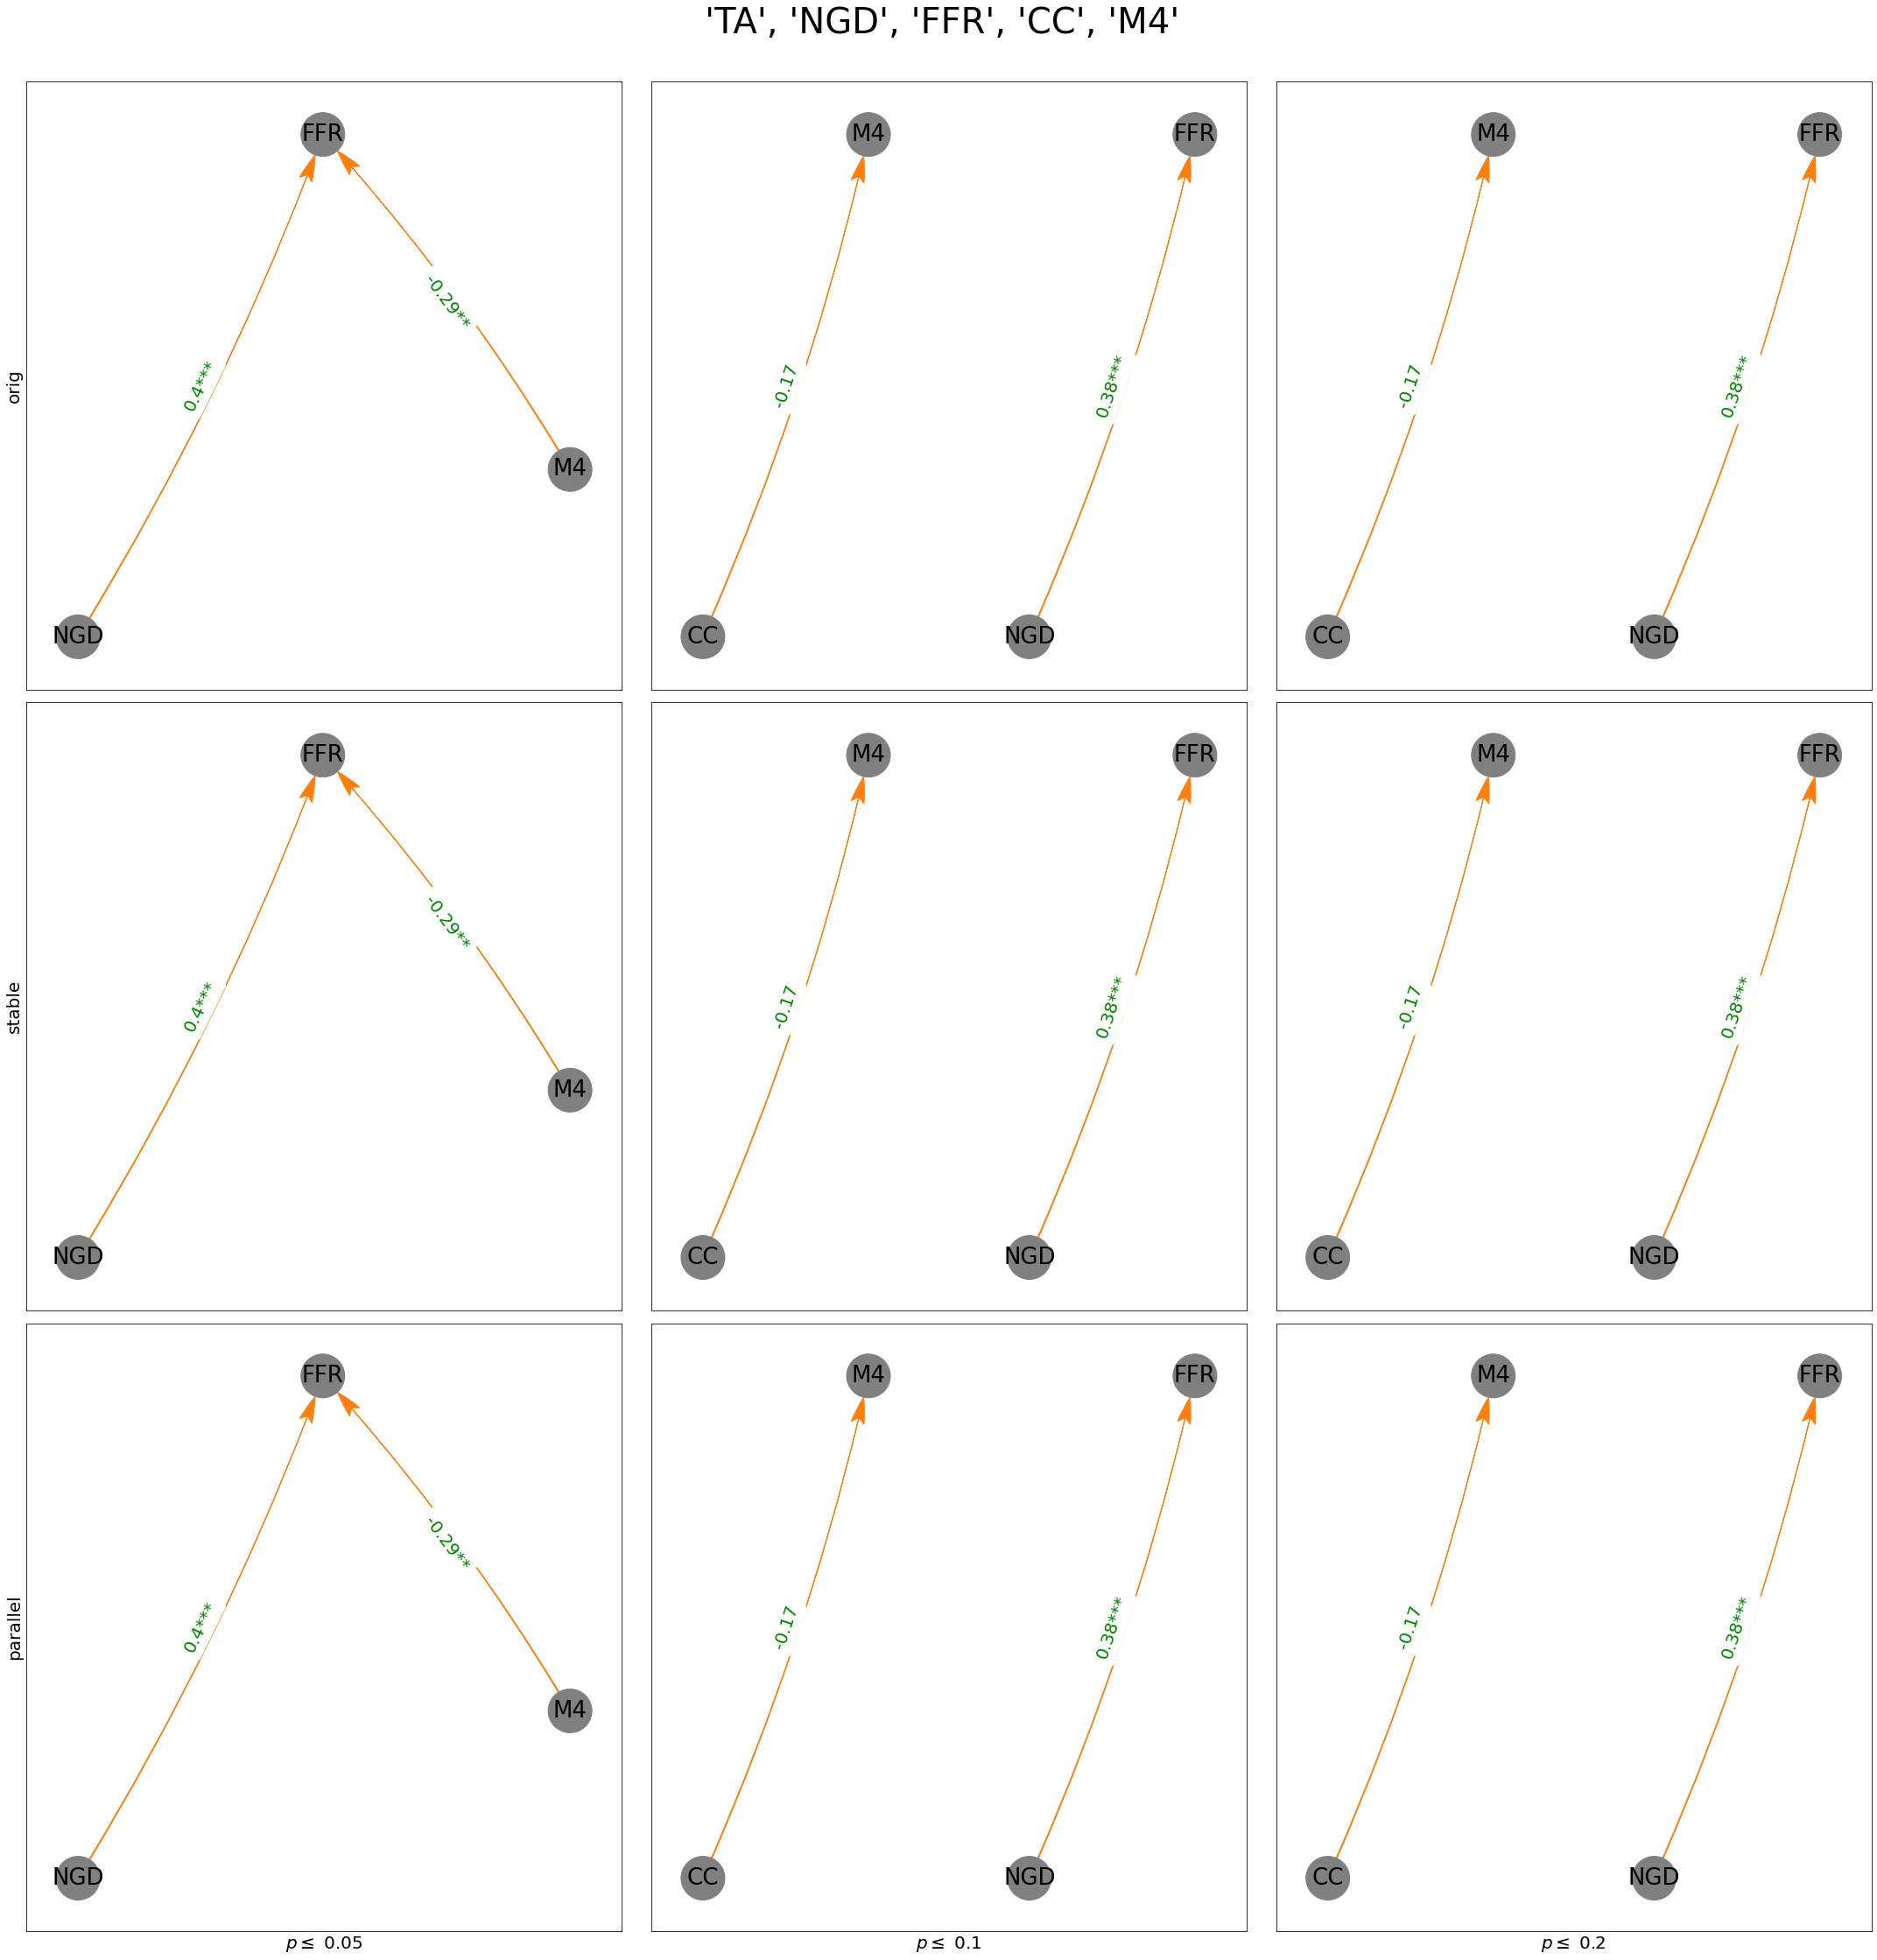

OutEdgeView([('NGD', 'FFR'), ('CC', 'M4')])

In [23]:
def graph_DAG(edges, data_reg, title = "", 
              fig = False, ax = False, 
              edge_labels = False,sig_vals = [0.05, 0.01, 0.001]):
    pcorr = data_reg.pcorr()
    graph = nx.DiGraph()
    def build_edge_labels(edges, df, sig_vals):
        edge_labels = {}
        for edge in edges:
            controls = [key for key in df.keys() if key not in edge]
            controls = list(set(controls))
            keep_controls = []
            for control in controls:
                control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
                if (control, edge[1]) in control_edges:
                    keep_controls.append(control)                
#             print(edge, keep_controls)
            pcorr = df.partial_corr(x = edge[0], y = edge[1], covar=keep_controls,
                                  method = "pearson")
            label = str(round(pcorr["r"][0],2))
            pvalue = pcorr["p-val"][0]
#             pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#             label = pcorr[edge[0]].loc[edge[1]]

            for sig_val in sig_vals:
                if pvalue < sig_val: 
                    label = label + "*"   
            
            edge_labels[edge] = label
        return edge_labels
    
    if edge_labels == False:
        edge_labels = build_edge_labels(edges, 
                                        data_reg, 
                                        sig_vals=sig_vals) 
    graph.add_edges_from(edges)
    color_map = ["grey" for g in graph]

    if fig == False and ax == False: fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    #pos = nx.spring_layout(graph)
    pos = graphviz_layout(graph)

    edge_labels2 = []
    for u, v, d in graph.edges(data=True):
        if pos[u][0] > pos[v][0]:  
            if (v,u) in edge_labels.keys():
                edge_labels2.append(((u, v,), f'{edge_labels[u,v]}\n\n\n{edge_labels[(v,u)]}'))  
        if (v,u) not in edge_labels.keys():
            edge_labels2.append(((u,v,), f'{edge_labels[(u,v)]}'))
    edge_labels = dict(edge_labels2)

    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 2500,
                     with_labels=True,  arrows=True,
                     font_color = "black",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                     connectionstyle='arc3, rad = 0.05',
                     ax = a)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20,
                                ax = a)
    

DAG_models_vars = {0:["CC", "TA", "NGDP"],
                  1:["FFR", "CC", "NGDP"],
                  2:["TA", "FFR", "NGDP"],
                  3:["TA", "NGDP", "FFR", "CC"],
                  4:["TA", "M4", "FFR", "CC"],
                  5:["TA", "NGDP", "FFR", "CC","M4"],}
# link_sigs = [0.05, 0.1, 0.2]
link_sigs = [0.05, .1, .2]
algorithms = ["orig", "stable", "parallel"]
for keys in DAG_models_vars.values():
    fig, ax = plt.subplots(len(algorithms), len(link_sigs), figsize = (30,30))
    max_cond_vars = len(keys) - 2
    data_reg = data[keys].dropna()
    data_reg.rename(columns = {col:firstLetterWord(col) for col in keys}, inplace = True)
    keys = data_reg.keys()
    c = PC(data_reg[keys].dropna())
    max_cond_vars = len(keys) - 2
    i,j = 0,0
    for sig in link_sigs:
        for algorithm in algorithms:
            model = c.estimate(return_type = "pdag", variant = algorithm, 
                               significance_level = sig, 
                               max_cond_vars = max_cond_vars, ci_test = "pearsonr")
            edges = model.edges()
            pcorr = data_reg.pcorr()
            weights = {}
            a = ax[i][j]
            graph_DAG(edges, data_reg, fig = fig, ax = a)
        
            if j == 0:
                a.set_ylabel(algorithm, fontsize = 20)
            if i == len(algorithms) - 1:
                a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 20)
            i += 1
        j += 1
        i = 0
    plt.suptitle(str(list(keys)).replace("[","").replace("]",""), fontsize = 40, y =1.035)
    plt.show()
    plt.close()
edges

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

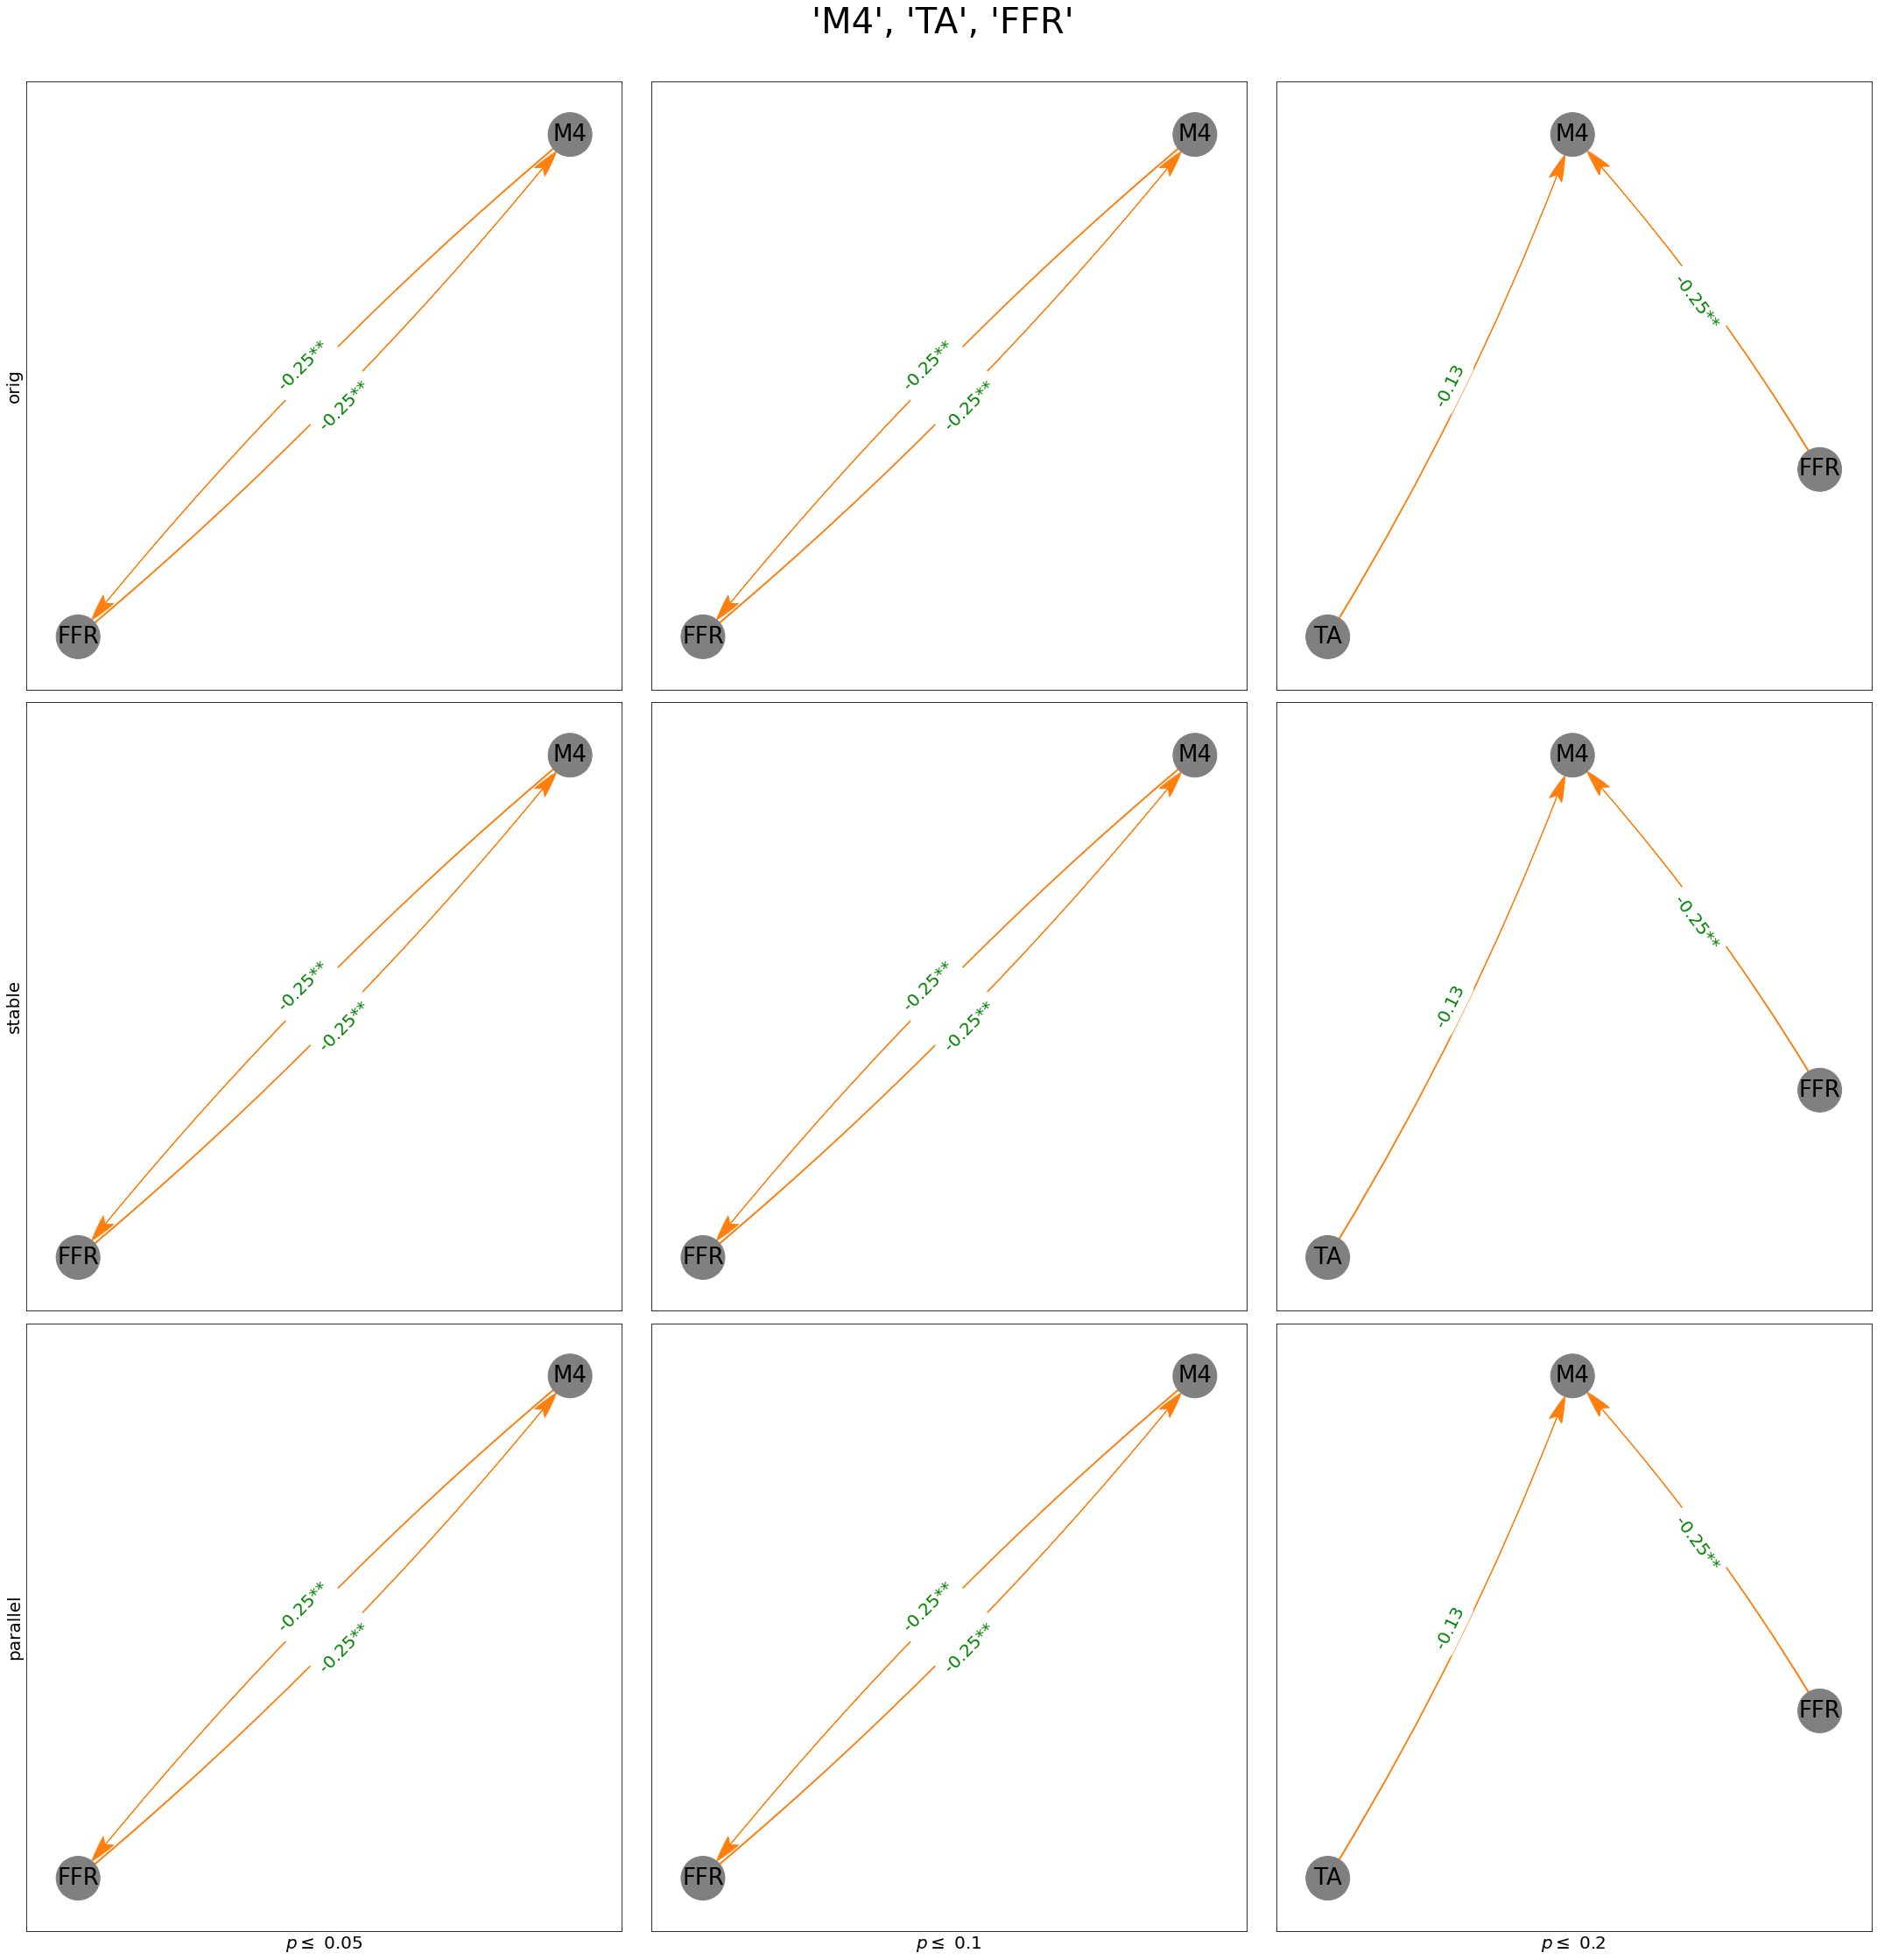

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

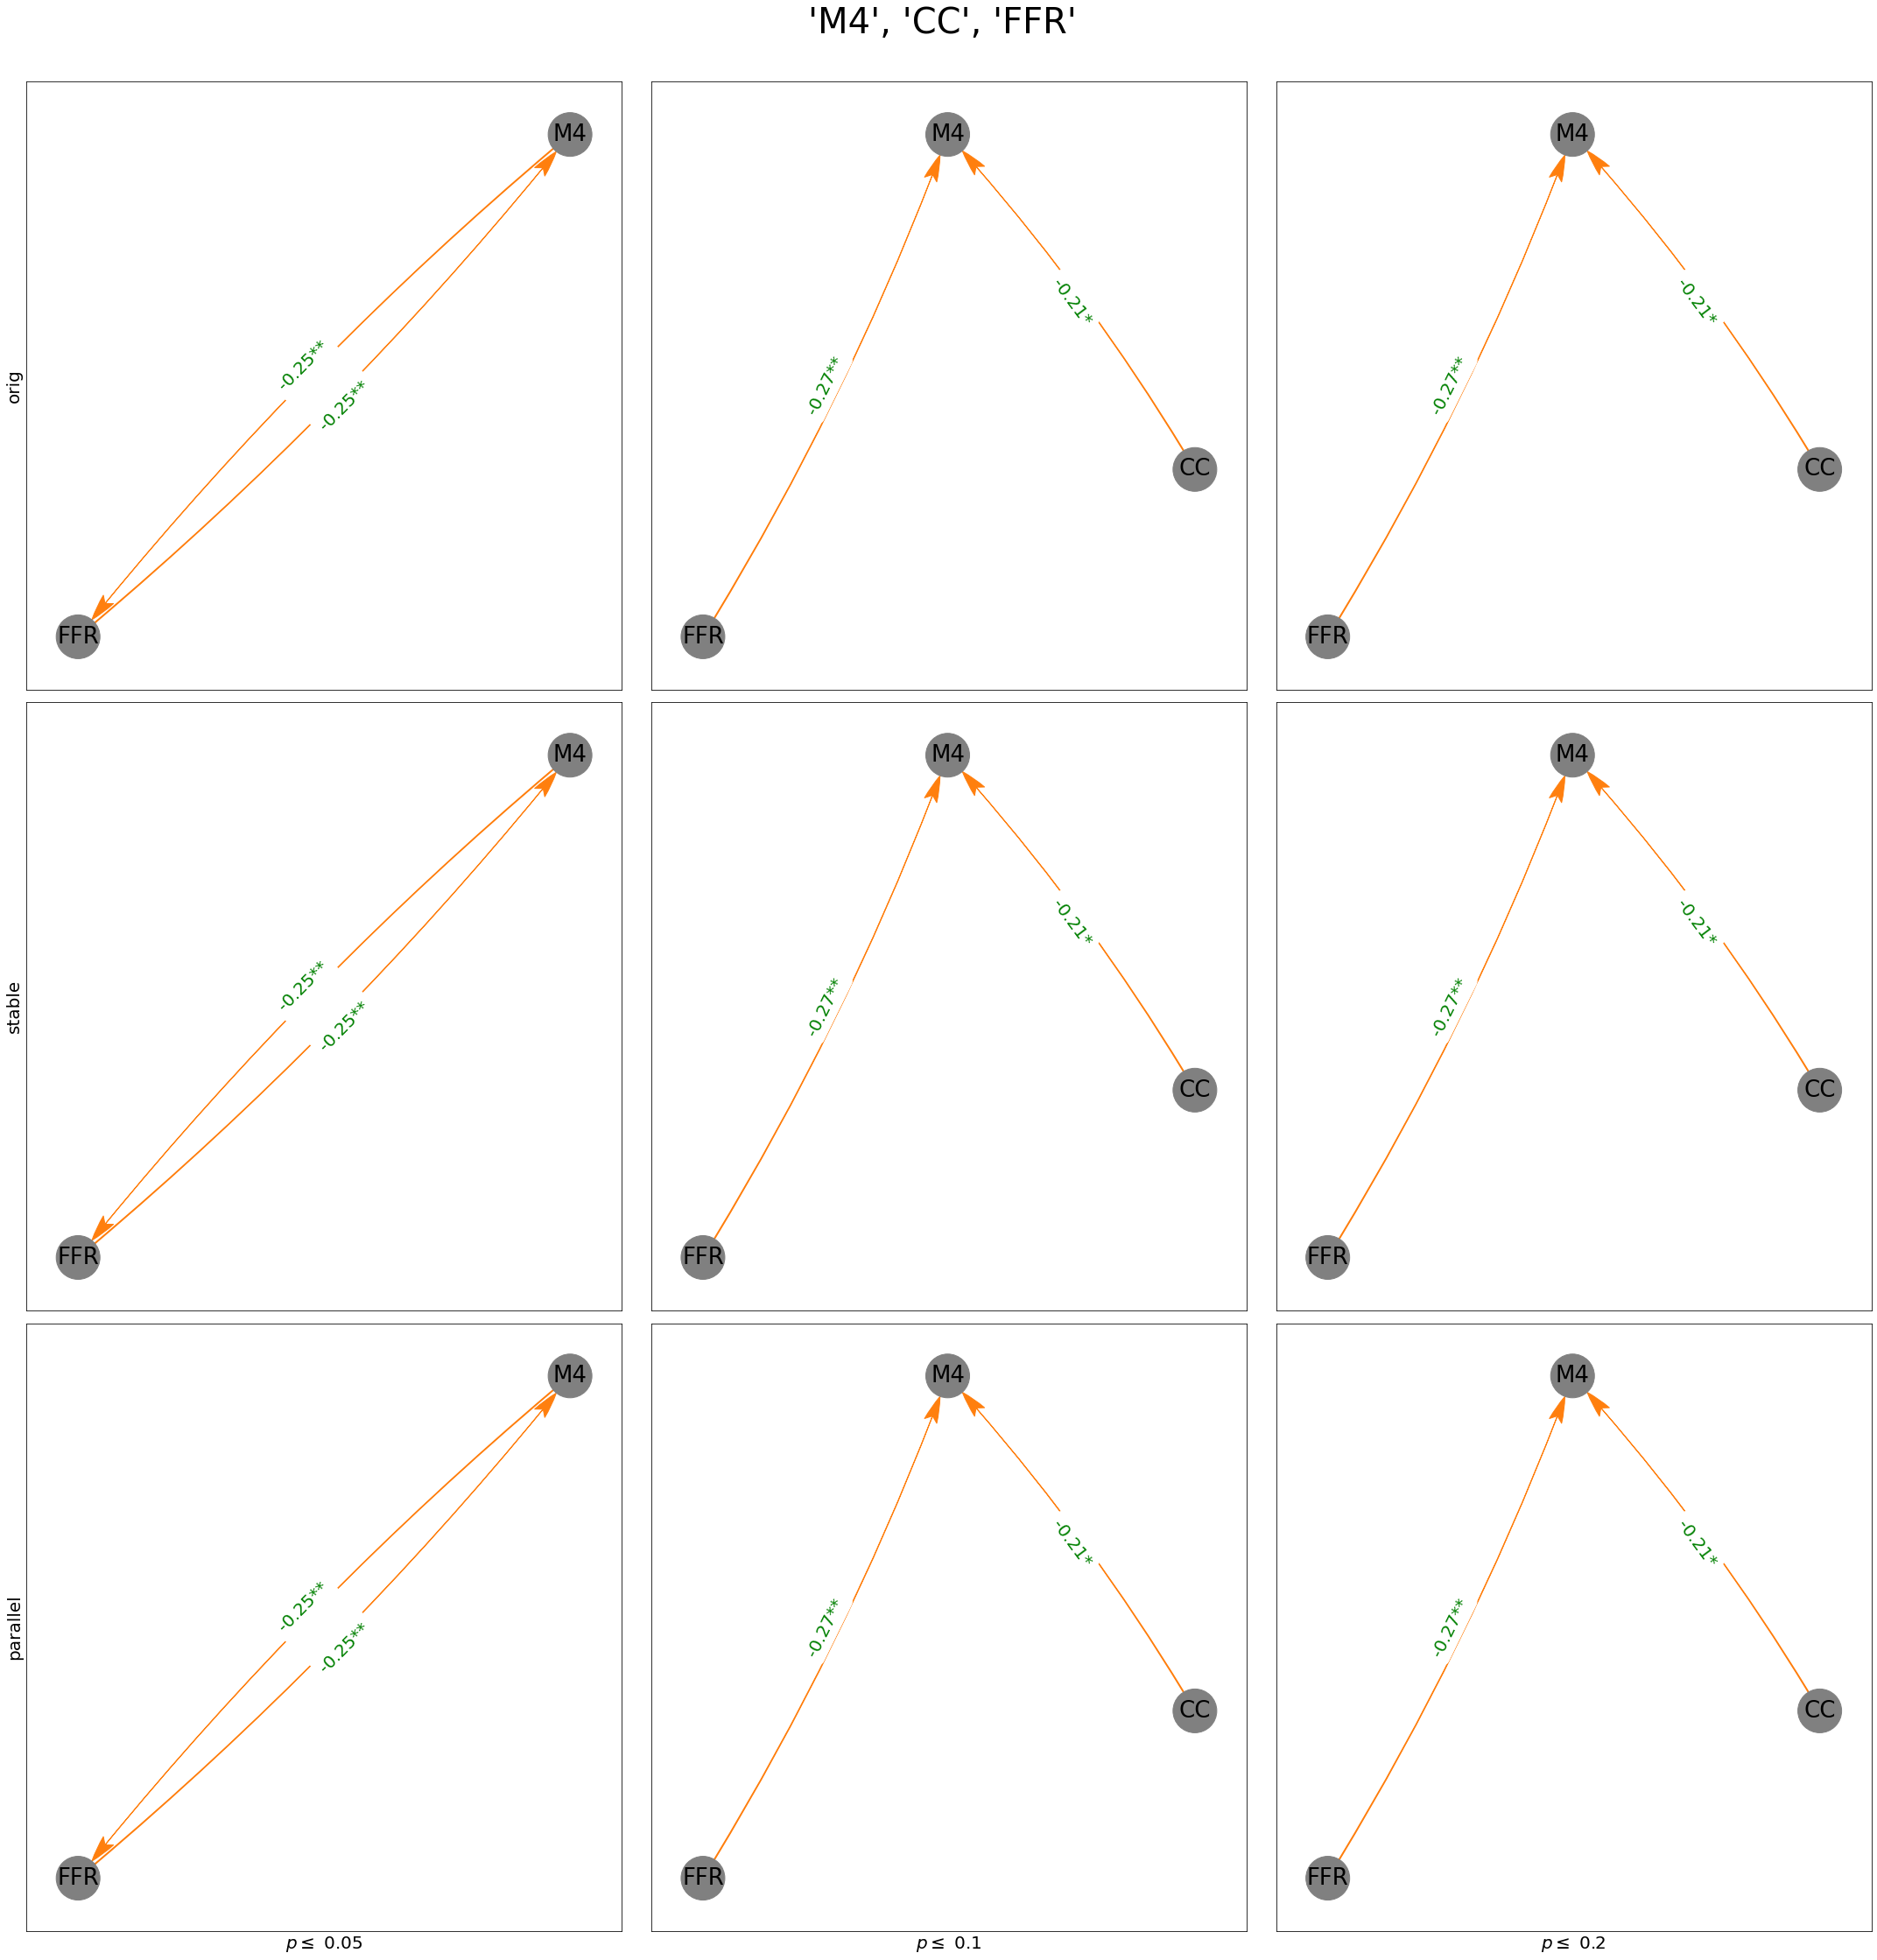

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

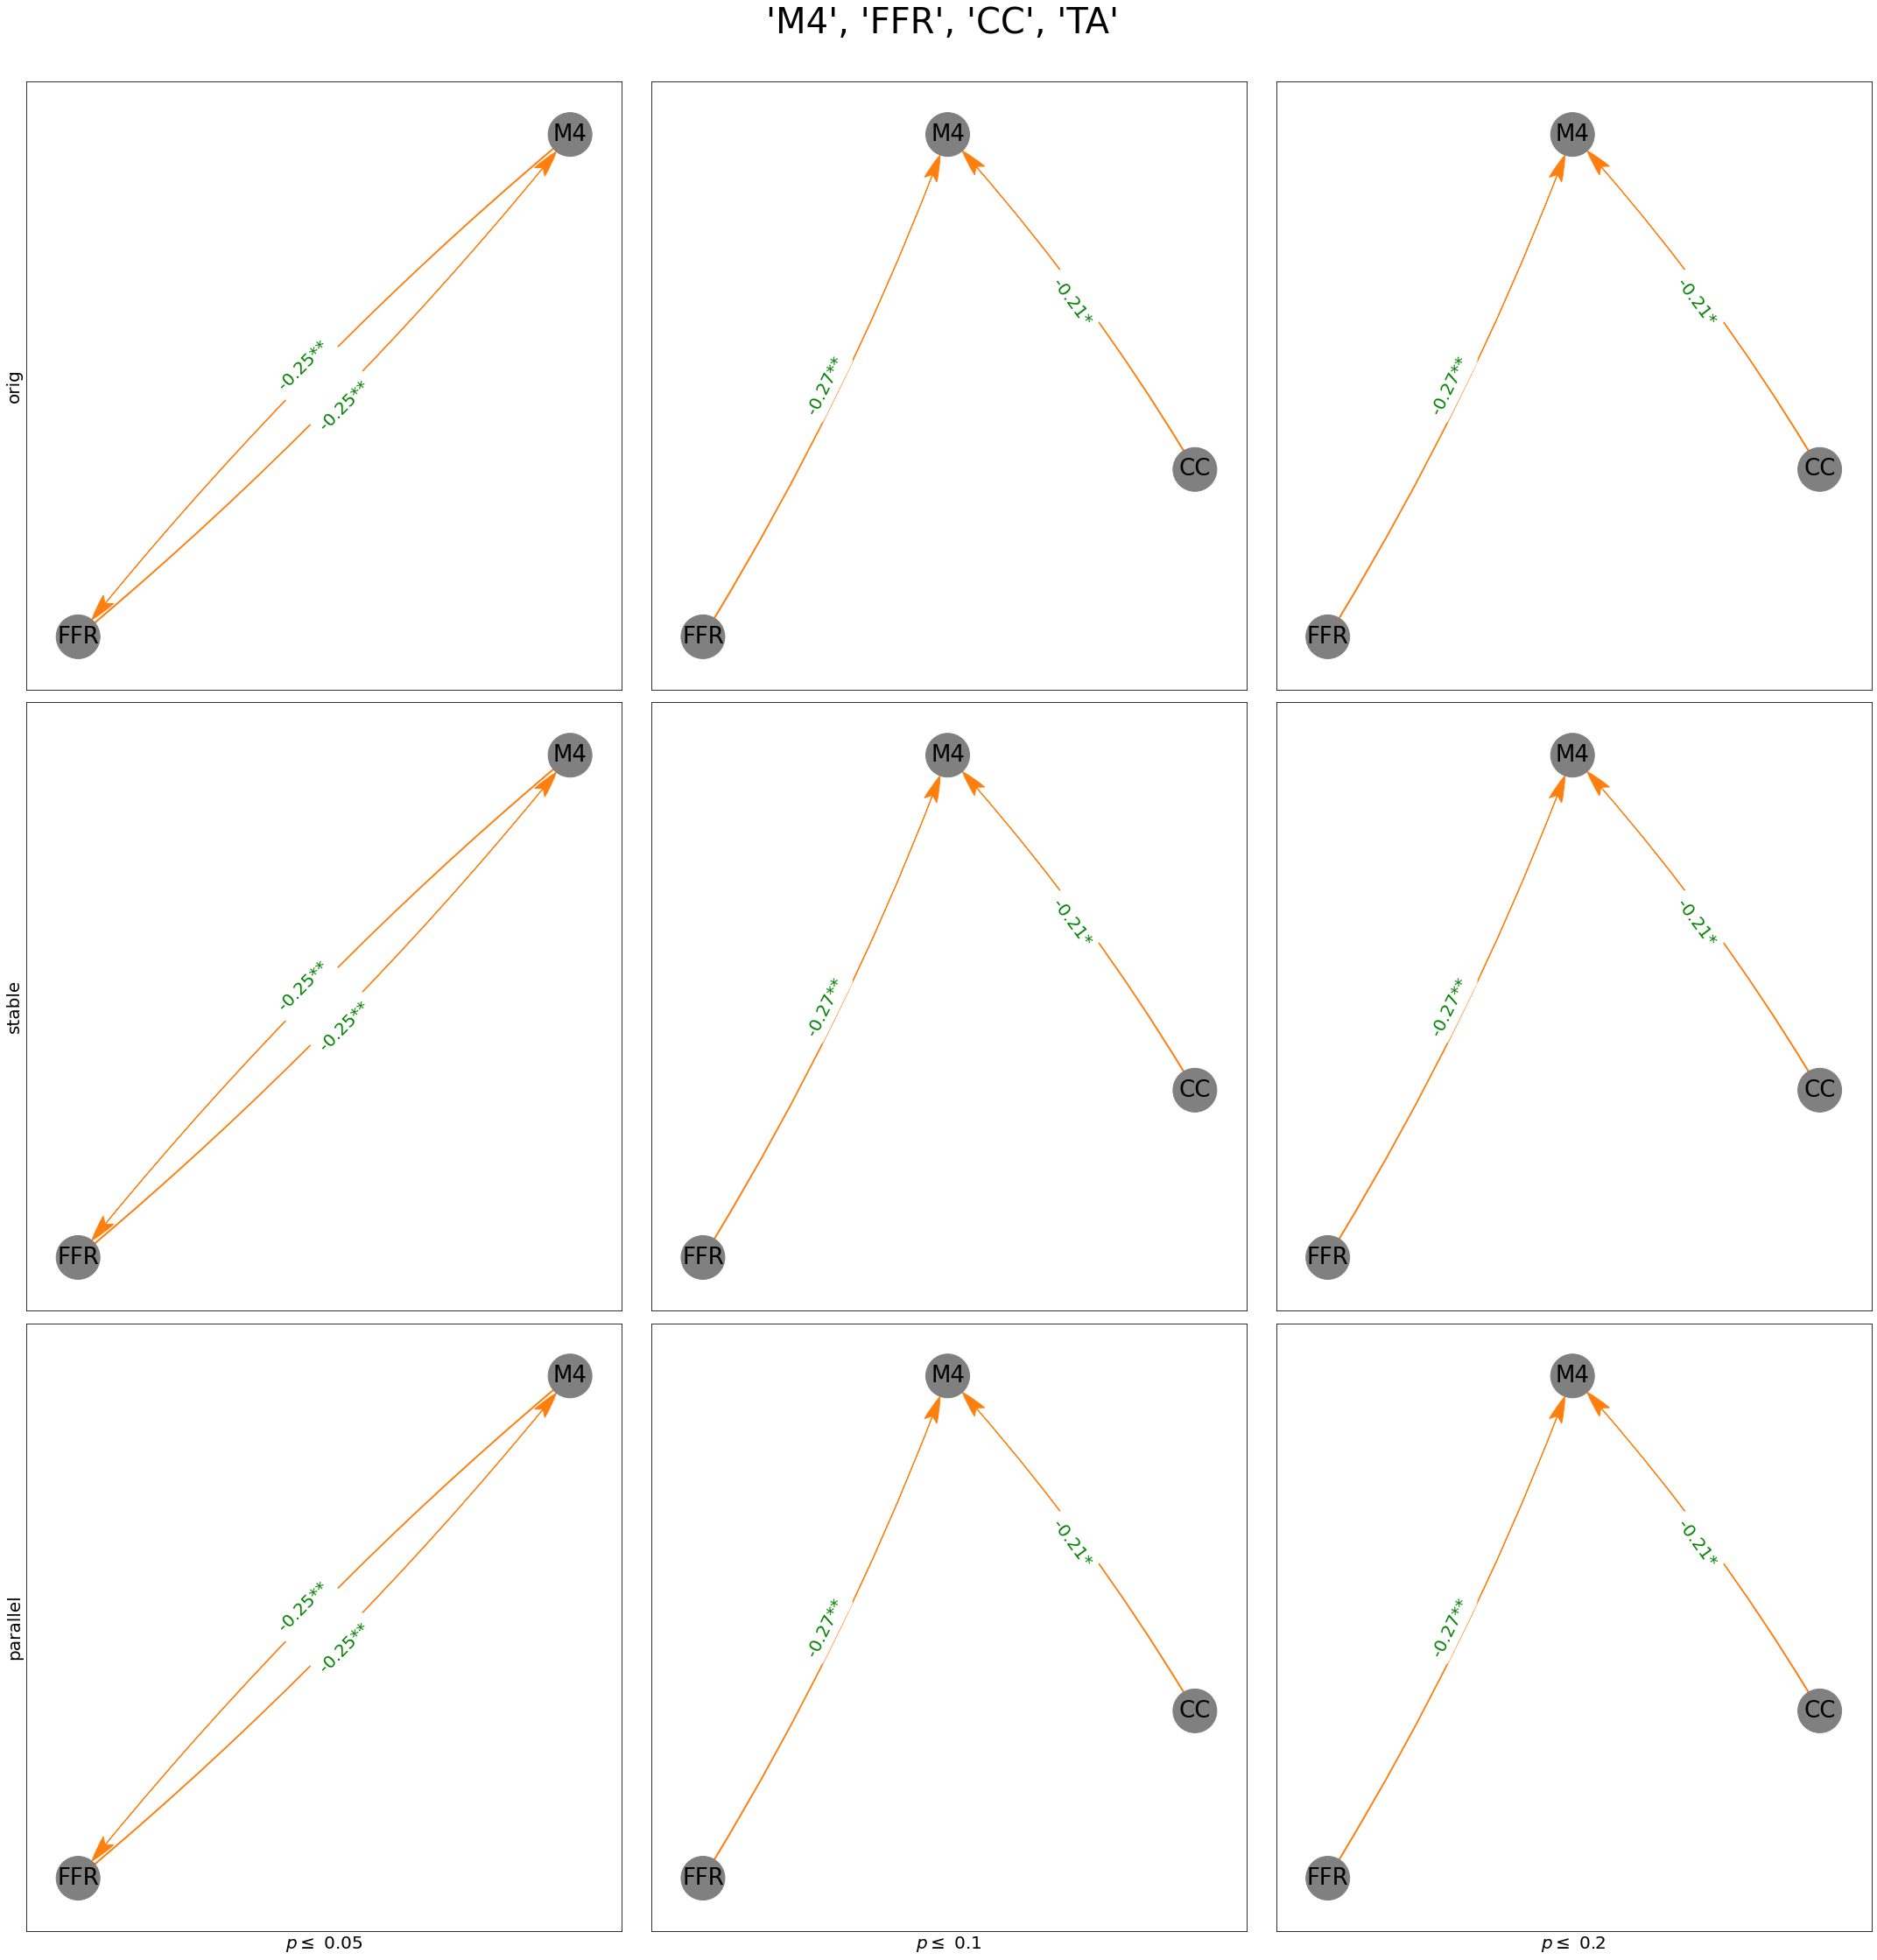

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

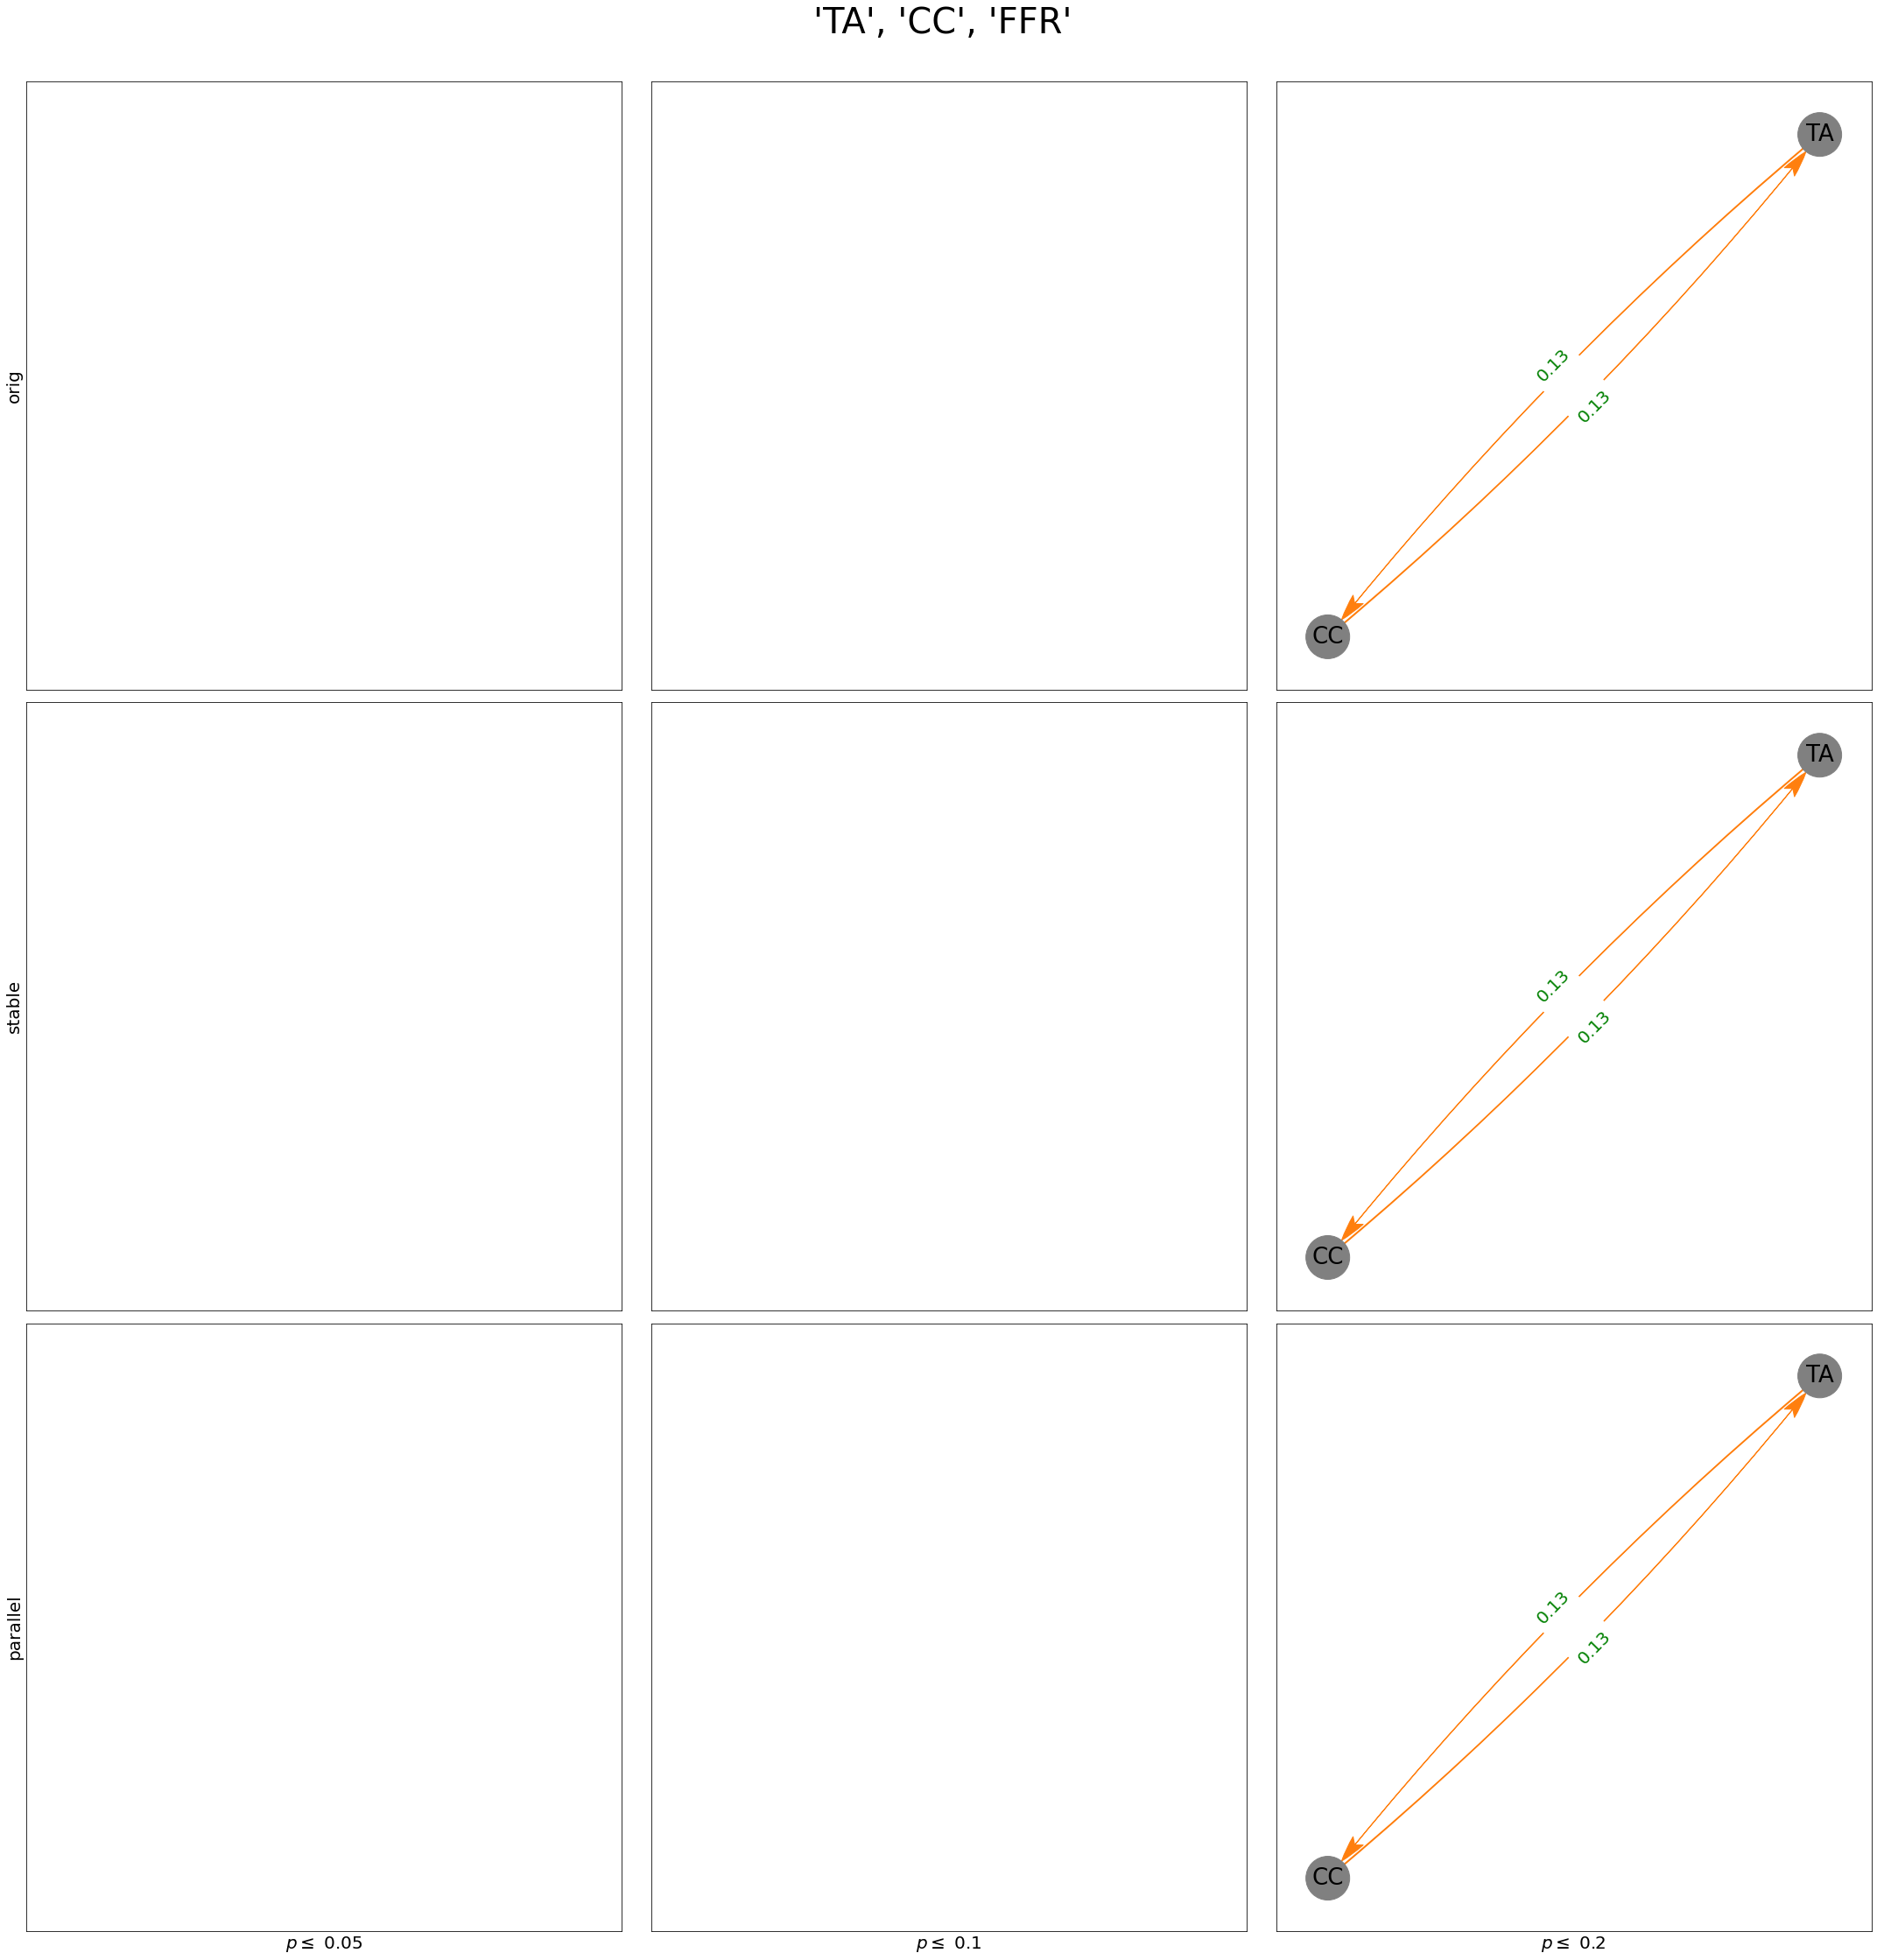

OutEdgeView([('CC', 'TA'), ('TA', 'CC')])

In [26]:
def graph_DAG(edges, data_reg, title = "", 
              fig = False, ax = False, 
              edge_labels = False,sig_vals = [0.05, 0.01, 0.001]):
    pcorr = data_reg.pcorr()
    graph = nx.DiGraph()
    def build_edge_labels(edges, df, sig_vals):
        edge_labels = {}
        for edge in edges:
            controls = [key for key in df.keys() if key not in edge]
            controls = list(set(controls))
            keep_controls = []
            for control in controls:
                control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
                if (control, edge[1]) in control_edges:
                    keep_controls.append(control)                
#             print(edge, keep_controls)
            pcorr = df.partial_corr(x = edge[0], y = edge[1], covar=keep_controls,
                                  method = "pearson")
            label = str(round(pcorr["r"][0],2))
            pvalue = pcorr["p-val"][0]
#             pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#             label = pcorr[edge[0]].loc[edge[1]]

            for sig_val in sig_vals:
                if pvalue < sig_val: 
                    label = label + "*"   
            
            edge_labels[edge] = label
        return edge_labels
    
    if edge_labels == False:
        edge_labels = build_edge_labels(edges, 
                                        data_reg, 
                                        sig_vals=sig_vals) 
    graph.add_edges_from(edges)
    color_map = ["grey" for g in graph]

    if fig == False and ax == False: fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    #pos = nx.spring_layout(graph)
    pos = graphviz_layout(graph)

    edge_labels2 = []
    for u, v, d in graph.edges(data=True):
        if pos[u][0] > pos[v][0]:  
            if (v,u) in edge_labels.keys():
                edge_labels2.append(((u, v,), f'{edge_labels[u,v]}\n\n\n{edge_labels[(v,u)]}'))  
        if (v,u) not in edge_labels.keys():
            edge_labels2.append(((u,v,), f'{edge_labels[(u,v)]}'))
    edge_labels = dict(edge_labels2)

    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 2500,
                     with_labels=True,  arrows=True,
                     font_color = "black",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                     connectionstyle='arc3, rad = 0.05',
                     ax = a)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20,
                                ax = a)
    

DAG_models_vars = {0:["M4", "TA", "FFR"],
                  1:["M4", "CC", "FFR"],
                  2:["M4", "FFR", "CC", "TA"],
                  3:["TA", "CC", "FFR"]}
# link_sigs = [0.05, 0.1, 0.2]
link_sigs = [0.05, .1, .2]
algorithms = ["orig", "stable", "parallel"]
for keys in DAG_models_vars.values():
    fig, ax = plt.subplots(len(algorithms), len(link_sigs), figsize = (30,30))
    max_cond_vars = len(keys) - 2
    data_reg = data[keys].dropna()
    data_reg.rename(columns = {col:firstLetterWord(col) for col in keys}, inplace = True)
    keys = data_reg.keys()
    c = PC(data_reg[keys].dropna())
    max_cond_vars = len(keys) - 2
    i,j = 0,0
    for sig in link_sigs:
        for algorithm in algorithms:
            model = c.estimate(return_type = "pdag", variant = algorithm, 
                               significance_level = sig, 
                               max_cond_vars = max_cond_vars, ci_test = "pearsonr")
            edges = model.edges()
            pcorr = data_reg.pcorr()
            weights = {}
            a = ax[i][j]
            graph_DAG(edges, data_reg, fig = fig, ax = a)
        
            if j == 0:
                a.set_ylabel(algorithm, fontsize = 20)
            if i == len(algorithms) - 1:
                a.set_xlabel("$p \leq$ "+ str(sig), fontsize = 20)
            i += 1
        j += 1
        i = 0
    plt.suptitle(str(list(keys)).replace("[","").replace("]",""), fontsize = 40, y =1.035)
    plt.show()
    plt.close()
edges